Let's build a pipeline for the registration of the slides.

# Imports

First, we import a bunch of necessary libraries.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.plot() # if we don't do that here, plt won't work normally from here on out

matplotlib.use('agg')

In our case, the block above throws a "bad key" warning. We decided not to worry about it.

In [2]:
import sys
sys.path.append('../wsi_processing_pipeline')
sys.path.append('../wsi_processing_pipeline/tile_extraction')
sys.path.append('/opt/conda/lib/python3.9/site-packages')

In [3]:
from PIL import Image, ImageDraw
import slide

from IPython.display import display, clear_output

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

In [6]:
# ! pip install SimpleITK

import SimpleITK as sitk
print()
print(sitk.Version())

# if import fails, check if SimpleITK's directory is appended to sys.path -> check directory using ! pip show SimpleITK

     |████████████████████████████████| 52.7 MB 8.7 MB/s eta 0:00:01

SimpleITK Version: 2.2.1 (ITK 5.3)
Compiled: Dec  2 2022 12:24:46



# The Registration Pipeline

## Pre-Registration automatizable image modification

First, let's open two slides to demonstrate the process:

In [5]:
ihc_slide = slide.open_slide('Testslides/test-sl-ACTH.ndpi')
he_slide = slide.open_slide('Testslides/test-sl-III-HE.ndpi')
level = 5
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])
ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])

In [58]:
def display_n_2d_arrays(imagelist, fig_size=None, cmap=[], titles=[]):
    n = len(imagelist)
    if len(cmap) != n:
        cmap = n*['gray']
    if len(titles) != n:
        titles = n*['']
    if fig_size == None:
        fig_size = ((int)(n*5),8)
    plt.subplots(1,n,figsize=fig_size)
    
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(imagelist[i], cmap[i], vmin=0, vmax=255)
        plt.axis('off')
        plt.title(titles[i])
    
    plt.show()

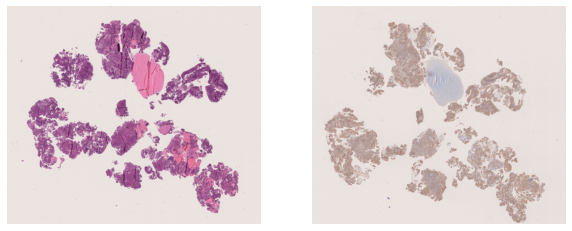

In [7]:
display_n_2d_arrays([he_pic, ihc_pic])

For registration, it's optimal to grayscale the image and invert colors, making the background black.

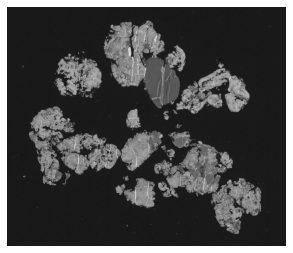

In [8]:
import PIL.ImageOps

he_inv =  PIL.ImageOps.invert(he_pic.convert('L'))
display_n_2d_arrays([he_inv], cmap=['gray'])

`PIL.ImageOps`' autocontrast function proved to be a good option for registration.

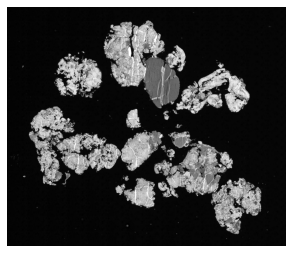

In [9]:
he_inv_contrast = PIL.ImageOps.autocontrast(
    Image.fromarray((np.array(he_inv)).astype('uint8'), mode='L'),1)

display_n_2d_arrays([he_inv_contrast], cmap=['gray'])

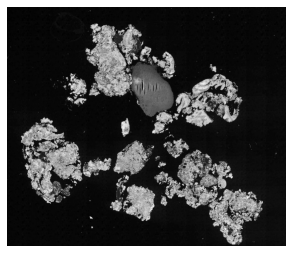

In [10]:
ihc_inv =  PIL.ImageOps.invert(ihc_pic.convert('L'))
ihc_inv_contrast = PIL.ImageOps.autocontrast(
    Image.fromarray((np.array(ihc_inv)).astype('uint8'), mode='L'),1)

display_n_2d_arrays([ihc_inv_contrast], cmap=['gray'])

Enhancing the foreground-background contrast even more proved useful.
The following, therefore, is the complete algorithm.

In [11]:
from PIL import ImageEnhance
def get_contrast_image(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=1)
        ).enhance(3),
    cutoff=5)
display_n_2d_arrays([get_contrast_image(ihc_pic)], cmap=['gray'])

To make registration possible, we also have to make both images the same size.

Let's have this size be double the larger size of the two images, in x and y respectively.

In [12]:
he_inv_contrast.size

(1568, 1344)

In [13]:
ihc_inv_contrast.size

(1568, 1344)

In [14]:
doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
              2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
doublesize

(3136, 2688)

In [15]:
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

This is a condition in which we can finally let the algorithm do its best.

## Display alternating images using `interact`

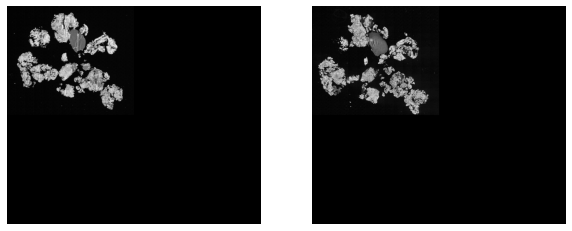

In [16]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast], cmap=['gray', 'gray'])

With the following function, it's possible to look at the difference of the pictures as easily as possible:

Please note! Any outputs of `interact` widgets can only be displayed during runtime. If you're reading this notebook without executing it, you're missing out on this visual feedback.

In [19]:
# to test the interact widget
interact(lambda x: x*x, x=(0,10))

interactive(children=(IntSlider(value=5, description='x', max=10), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(x)>

In [21]:
def displayAlternating(imArr, displayslider):
    display_n_2d_arrays([imArr[displayslider]], cmap=['gray'])
        
displayArr = [he_inv_contrast, ihc_inv_contrast]
interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

## Translation Registration

### Center of mass translation initialization

Some slides aren't registrable without an initial approximation. This can be provided automatically using a "center of mass" approach:

In [33]:
import scipy.ndimage as ndi

In [20]:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
he_com_yx

(665, 793)

In [21]:
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))
ihc_com_yx

(729, 780)

For demonstration, we will use copies of the original images:

In [22]:
he_copy = he_inv_contrast.copy()
ihc_copy = ihc_inv_contrast.copy()

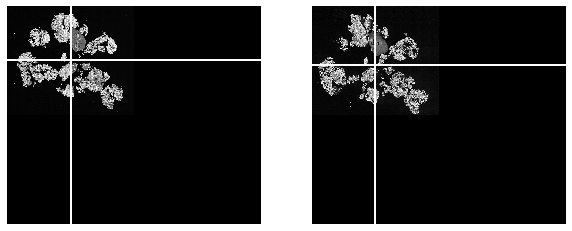

In [23]:
draw = ImageDraw.Draw(he_copy)
draw.line((he_com_yx[1],0, he_com_yx[1],he_inv_contrast.size[1]), fill=255, width=20)
draw.line((0,he_com_yx[0], he_inv_contrast.size[0], he_com_yx[0]), fill=255, width=20)
draw2 = ImageDraw.Draw(ihc_copy)
draw2.line((ihc_com_yx[1],0, ihc_com_yx[1],ihc_inv_contrast.size[1]), fill=255, width=20)
draw2.line((0,ihc_com_yx[0], ihc_inv_contrast.size[0], ihc_com_yx[0]), fill=255, width=20)
display_n_2d_arrays([he_copy, ihc_copy], cmap=['gray', 'gray'])

In [24]:
(he_com_yx[1]-ihc_com_yx[1], he_com_yx[0]-ihc_com_yx[0])

(13, -64)

The difference is not remarkable here, but in other images, it will be.

### Automatic translation registration

Let's see now if automatic translation returns a reasonable result.

In [37]:
import time

In [26]:
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# auto-generated initial translation
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_ini_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
moving_im_ini_pil = Image.fromarray(sitk.GetArrayViewFromImage(moving_im_ini_trltd))

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=100)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration = time.time() - timestart

In [27]:
round(reg_duration*1000)

5124

The process took about 5 seconds. Let's look at the result:

In [28]:
moving_im2 = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
moving_im2_pil = Image.fromarray(sitk.GetArrayViewFromImage(moving_im2))

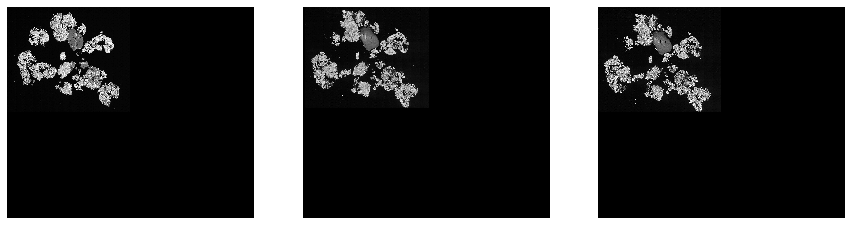

In [29]:
fixed_pil = Image.fromarray(sitk.GetArrayViewFromImage(fixed_image))
moving_pil = Image.fromarray(sitk.GetArrayViewFromImage(moving_image))
display_n_2d_arrays([fixed_pil,
                     moving_im2_pil,
                     moving_pil],
                   cmap = ['gray']*3)

In [30]:
displayArr = [fixed_pil, moving_im2_pil, moving_pil, fixed_pil]
interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=3), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

Awesome! Automatic translation registration seems to work.

## SSIM

It turns out that it's sometimes wise to double check at any point if the previous registration actually made the moving image more similar to the fixed image. For that, we will use the SSIM metric:

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim

def calculateSSIM(im1, im2):
    im1Weird = np.array(im1.convert('L')).astype(float)/255
    im2Weird = np.array(im2.convert('L')).astype(float)/255
    maxwinsize = min(im1.size[0], im1.size[1])
    if maxwinsize%2==0:
        maxwinsize -= 1
#     return round(ssim(im1Weird, im2Weird, win_size=maxwinsize), 4)
    return ssim(im1Weird, im2Weird, win_size=maxwinsize)

In [32]:
print("The initial translation resulted in this SSIM:")
print(round(calculateSSIM(fixed_pil, moving_im_ini_pil), 4))
print("The registered translation resulted in this SSIM:")
print(round(calculateSSIM(fixed_pil, moving_im2_pil), 4))

The initial translation resulted in this SSIM:
0.6273
The registered translation resulted in this SSIM:
0.6684


## The Full Algorithm

After this demonstration of translation registration, we will create the full registration algorithm, and explain affine and BSpline transformations on the fly.

First, we need to import our `pair_df` that we created in notebooks 1 and 2.

In [33]:
import pathlib
from pathlib import Path
output_path = Path('Output')

import pandas as pd
pair_df = pd.read_csv(output_path/'pairlist_df_after_notebook_2.csv')

In [34]:
pair_df.head(3)

(classified)


We will iterate over these entries.

In [35]:
level = 7
# we will save transformations here:
OUTPUT_DIR_TFMS_AFF = 'Output/Transforms/1 Affines'
OUTPUT_DIR_TFMS_BSP = 'Output/Transforms/2 BSplines'
from PIL import Image
from datetime import datetime
import pytz
tz = pytz.timezone("Europe/Berlin")
print(datetime.now(tz).strftime("%d.%m.%Y, %H:%M:%S"))

20.04.2023, 13:17:38


In [36]:
import os

In [37]:
Path('Output/Transforms').mkdir(exist_ok=True)
Path(OUTPUT_DIR_TFMS_AFF).mkdir(exist_ok=True)
Path(OUTPUT_DIR_TFMS_BSP).mkdir(exist_ok=True)

Further explanations are contained within the code:

In [ ]:
def registerPairs(df_to_reg, attemptNo):
    with open('out.txt', 'a+') as f:
        print("Starting attempt #"+str(attemptNo), file = f)

    BSP_BOUNDS = 20 # BSpline registration bounds
                    # this value ensures that the moving image isn't being deformed in the presence of rips and holes
    NUM_OF_HISTOGRAM_BINS = 10
#     df_to_reg.reset_index(drop=True, inplace=True) # it's important that we don't reset the index. Otherwise, we can't refer to pair_df rows
    for index, pair in df_to_reg.iterrows():
        success = False # we will print an error later if success isn't True
        timestartThisCase = time.time() # measure time for the whole case
        for j in range(3): # we give each pair a maximum of three attempts before printing an error
            try:
                pair_ihc_name = pair["ihc name"]
                pair_he_name = pair["he name"]
                ihc_slide = slide.open_slide(pair["ihc path"])
                he_slide = slide.open_slide(pair["he path"])

                ihc_pic = ihc_slide.read_region((0,0),
                                                 level,
                                                 ihc_slide.level_dimensions[level])
                he_pic = he_slide.read_region((0,0),
                                             level,
                                             he_slide.level_dimensions[level])
                ihc_inv_contrast = get_contrast_image(ihc_pic)
                he_inv_contrast = get_contrast_image(he_pic)
                doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
                          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
                he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
                ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
                
                # center of mass:
                he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
                he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
                ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
                ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))
                
                # our pre-registration algorithm is now concluded
                # Now let's register!
                fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
                moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

                # First, the translation
                trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
                moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

                trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
                registration_method = sitk.ImageRegistrationMethod()
                registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
                registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
                registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
                registration_method.SetInterpolator(sitk.sitkLinear)
                registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                                  numberOfIterations=100, # 100 iterations suffice for trl. reg.
                                                                  convergenceMinimumValue=1e-6,
                                                                  convergenceWindowSize=1000)
                registration_method.SetOptimizerScalesFromPhysicalShift()
                registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
                registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
                registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
                registration_method.SetInitialTransform(trl_transform)

                # measure time
                timestart = time.time()
                registration_method.Execute(fixed_image, moving_image)
                reg_duration_ms = round((time.time() - timestart)*1000)

                # this is where the fact comes into play that we didn't call df_to_reg.reset_index earlier
                pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

                # in order to continue, we need to resample our moving image
                moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
                
                # calculate similarities:
                he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
                ssim_trltd_ini = calculateSSIM(
                    he_comparison_img,
                    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
                )
                ssim_trltd = calculateSSIM(
                    he_comparison_img,
                    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
                )

                # Use only the best transformation
                aff_transform_best = trl_transform
                moving_im_best_aff = moving_im_trltd
                ssim_best_aff = ssim_trltd
                best_aff_str = "reg trl"
                if ssim_trltd_ini > ssim_trltd:
                    aff_transform_best = trl_transform_ini
                    moving_im_best_aff = moving_im_trltd_ini
                    ssim_best_aff = ssim_trltd_ini
                    best_aff_str = "initial trl"


                # Secondly, register a rotation transformation.
                transform_eul = sitk.Euler2DTransform()
                transform_eul.SetTranslation(aff_transform_best.GetParameters())
                he_com_xy = (he_com_yx[1], he_com_yx[0])
                transform_eul.SetCenter(he_com_xy)

                # Note that we don't use `sitk.CenteredTransformInitializer`.
                # It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
                registration_method = sitk.ImageRegistrationMethod()
                registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
                registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
                registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
                registration_method.SetInterpolator(sitk.sitkLinear)
                registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                                  numberOfIterations=100,
                                                                  convergenceMinimumValue=1e-6,
                                                                  convergenceWindowSize=1000)
                registration_method.SetOptimizerScalesFromPhysicalShift()
                registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
                registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
                registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
                registration_method.SetInitialTransform(transform_eul)

                # measure time
                timestart = time.time()
                registration_method.Execute(fixed_image, moving_image)
                reg_duration_ms = round((time.time() - timestart)*1000)

                pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

                # again, we need to resample our moving image
                moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

                # calculate similarities:
                ssim_euld = calculateSSIM(
                    he_comparison_img,
                    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
                )

                # Use only the best transformation
                best_aff_is_trl = True
                if ssim_euld > ssim_best_aff:
                    aff_transform_best = transform_eul
                    moving_im_best_aff = moving_im_euld
                    ssim_best_aff = ssim_euld
                    best_aff_is_trl = False
                    best_aff_str = "reg eul"


                # Thirdly, register an affine transformation
                transform_aff = sitk.AffineTransform(2)
                transform_aff.SetCenter(he_com_xy)
                if best_aff_is_trl:
                    transform_aff.SetTranslation(aff_transform_best.GetParameters())
                else:
                    if hasattr(aff_transform_best,"GetMatrix"):
                        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
                    if hasattr(aff_transform_best,"GetTranslation"):
                        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
                    if hasattr(aff_transform_best,"GetCenter"):
                        transform_aff.SetCenter(aff_transform_best.GetCenter())

                registration_method = sitk.ImageRegistrationMethod()
                registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
                registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
                registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
                registration_method.SetInterpolator(sitk.sitkLinear)
                registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                                  numberOfIterations=100,
                                                                  convergenceMinimumValue=1e-6,
                                                                  convergenceWindowSize=1000)
                registration_method.SetOptimizerScalesFromPhysicalShift()
                registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
                registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
                registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
                registration_method.SetInitialTransform(transform_aff)

                # measure time
                timestart = time.time()
                registration_method.Execute(fixed_image, moving_image)
                reg_duration_ms = round((time.time() - timestart)*1000)

                pair_df.loc[index, 'aff registration duration'] = reg_duration_ms
                
                # again, we need to resample our moving image
                moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

                # calculate similarities:
                ssim_affd = calculateSSIM(
                    he_comparison_img,
                    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
                )

                # Use only the best transformation
                if ssim_affd > ssim_best_aff:
                    aff_transform_best = transform_aff
                    moving_im_best_aff = moving_im_affd
                    best_aff_str = "reg aff"
                
                # save the best affine transformation
                aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
                sitk.WriteTransform(aff_transform_best, aff_path)
                
                pair_df.loc[index, 'aff path'] = aff_path
                pair_df.loc[index, 'best aff tfm'] = best_aff_str
                
                
                # Finally, the BSpline transformation.
                # This nonlinear transformation helps close the gap between the moving and the fixed image.
                # Small incongruences are straightened out.
                transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
                tx = sitk.BSplineTransformInitializer(fixed_image,
                                                      transformDomainMeshSize)
                R = sitk.ImageRegistrationMethod()
                R.SetMetricAsCorrelation()
                R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                                       numberOfIterations=150,
                                       maximumNumberOfCorrections=5,
                                       maximumNumberOfFunctionEvaluations=1000,
                                       costFunctionConvergenceFactor=1e+10,
                                       lowerBound = -1*BSP_BOUNDS,
                                       upperBound = BSP_BOUNDS)
                R.SetInitialTransform(tx, True)
                R.SetInterpolator(sitk.sitkLinear)

                # measure time
                timestart = time.time()
                outTx = R.Execute(fixed_image, moving_im_best_aff)
                reg_duration_ms = round((time.time() - timestart)*1000)

                # save the bspline transform
                bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
                sitk.WriteTransform(outTx, bsp_path)

                pair_df.loc[index, 'bsp path'] = bsp_path
                pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms
                
                pair_df.loc[index, 'attempts'] = attemptNo
                success = True

                with open('out.txt', 'a+') as f:
                    print(datetime.now(tz).strftime("%d.%m.%Y, %H:%M:%S") + ': index ' + str(index) + ' successful', file=f)  # Python 3.x

                break
            except:
                # if an error is thrown, we want to log it together with a timestamp and the index
                with open('out.txt', 'a+') as f:
                    print(datetime.now(tz).strftime("%d.%m.%Y, %H:%M:%S") + ': index ' + str(index) + ' error' + str(j) + ':', file=f)  # Python 3.x
                    print(sys.exc_info()[0], file=f)
                continue
        if not success:
            # after three attempts, log this message:
            with open('out.txt', 'a+') as f:
                print(datetime.now(tz).strftime("%d.%m.%Y, %H:%M:%S") + ': PROBLEM WITH INDEX ' + str(index) + ", MOVING ON", file=f)  # Python 3.x
            
        # save the time everything took:
        full_duration_ms = round((time.time() - timestartThisCase)*1000)
        pair_df.loc[index, 'full duration'] = full_duration_ms

        # finally, save our pair_df-changes
        pair_df.to_csv(output_path/'pairlist_df_3-2.csv', index=False)
                
# # This function call is commented out because we only want to execute it once. Uncomment for execution
# registerPairs(pair_df, 1)

# Looking at Results

## The strategy

Jupyter Notebook enables us to evaluate, categorize and adjust the results — even though the code might not be the easiest to get into.

(Please note: The following explanations will not make much sense if you haven't read the paper)

Our strategy here uses two code cells with an interact widget:
- In Interact Cell A: Look at every pair to determine whether or not is was automatically registered correctly. If it wasn't, tag it with "rerun" or "graphic changes" (see below), rotate it, or use Interact Cell B.
- In Interact Cell B: Adjust cropping values for multi-configuration pairs (see below) and "graphic changes". Execute only if index is loaded in Cell A, since they share the same value.

It is our goal to save every necessary information in `pair_df` to make a semi-automatic registration (i.e., fully automatic, but only after manual value adjustments) possible for each pair.

There will be two important changes to the structure of `pair_df`:
1. More columns: we will save values and tags in the dataframe, like "crop" and "rotation"
2. More rows: Whenever there's a pair of WSIs where more than just one pair configuration is possible ("multi-configuration pairs"), we want to add one row per configuration to the dataframe.

In [35]:
pair_df = pd.read_csv(output_path/'pairlist_df_3-2.csv')

In [36]:
pair_df["crop ihc left"] = 0
pair_df["crop ihc top"] = 0
pair_df["crop ihc right"] = 0
pair_df["crop ihc bottom"] = 0
pair_df["crop he left"] = 0
pair_df["crop he top"] = 0
pair_df["crop he right"] = 0
pair_df["crop he bottom"] = 0
pair_df["rotate ihc degrees"] = 0

pair_df["needed adjustments"] = False # true for any change, except for a plain "rerun"
pair_df["multiple configs"] = False
pair_df["graphic changes"] = False
pair_df["rerun"] = False
pair_df["unusable"] = False
pair_df

(classified)


Why "rerun"? Because there will be pairs where another blind run of the algorithm could be beneficial, since it had probably been bad luck that had resulted in a bad transformation.

And what does "graphic changes" mean? It means that some cases can't be registered without manual changes using an image manipulation program. With this program, we can create bitmaps "telling" the registration algorithm which parts of the tissue belongs to which.

We will save these new columns to file now.

In [37]:
pair_df.to_csv(output_path/'pairlist_df_3-3-1.csv', index=False)

Finally: If **you** are running this code and feel unprepared to categorize pairs, feel free to read the next section, in which we discuss and handle registration problems.

## Variables and functions

In [29]:
import pathlib
from pathlib import Path
output_path = Path('Output')

import pandas as pd
pair_df = pd.read_csv(output_path/'pairlist_df_3-3-3.csv')

In [30]:
# the index that both cells use
global_index = 0

MAX_DF_IND = len(pair_df)-1

# reminder: the level of detail we use is still 7
level = 7

### For Interact Cell A

In [31]:
callback_After_Iteration = None
def iterateAndClose(increment):
    global global_index, callback_After_Iteration
    global_index += increment
    clear_output()
    print("current index is now "+str(global_index))
    if callback_After_Iteration != None:
        callback_After_Iteration()
    else:
        print("please re-run this cell")
        
def incAndClose(button):
    iterateAndClose(1)
def decAndClose(button):
    iterateAndClose(-1)

def tag_rerun(button):
    global global_index, pair_df
    pair_df.loc[global_index, 'rerun'] = True
    pair_df.to_csv(output_path/'pairlist_df_3-3-3.csv', index=False)
    print("pair was tagged for rerun")

def tag_graphic(button):
    global global_index, pair_df
    pair_df.loc[global_index, 'graphic changes'] = True
    pair_df.loc[global_index, 'needed adjustments'] = True
    pair_df.to_csv(output_path/'pairlist_df_3-3-3.csv', index=False)
    print("pair was tagged for graphic changes")

def rotate_90(button):
    global global_index, pair_df
    oldval = pair_df.iloc[[global_index]].squeeze()["rotate ihc degrees"]
    newval = (oldval+90)%360
    pair_df.loc[global_index, 'rotate ihc degrees'] = newval
    pair_df.loc[global_index, 'rerun'] = True
    pair_df.loc[global_index, 'needed adjustments'] = True
    pair_df.to_csv(output_path/'pairlist_df_3-3-3.csv', index=False)
    clear_output()
    print("rotation is now "+str(newval) + " degrees")
    if callback_After_Iteration != None:
        callback_After_Iteration()
    else:
        print("the image was rotated")
        print("please re-run this cell")

def tag_unusable(button):
    global global_index, pair_df
    pair_df.loc[global_index, 'unusable'] = True
    pair_df.to_csv(output_path/'pairlist_df_3-3-3.csv', index=False)
    print("pair was tagged as unusable")

For Interact Cell A, we need both the fixed and the moving image (transformed).
To make the code faster, let's transform the ihc image only in greyscale here.

In [32]:
def loadAndShowPair():
    pair = pair_df.iloc[[global_index]].squeeze()

    pair_ihc_name = pair["ihc name"]
    pair_he_name = pair["he name"]
    ihc_slide = slide.open_slide(pair["ihc path"])
    he_slide = slide.open_slide(pair["he path"])

    ihc_pic = ihc_slide.read_region((0,0),
                                     level,
                                     ihc_slide.level_dimensions[level])
    if pair["rotate ihc degrees"] != 0:
        ihc_pic = ihc_pic.rotate(pair["rotate ihc degrees"], expand=True)
    he_pic = he_slide.read_region((0,0),
                                 level,
                                 he_slide.level_dimensions[level])
    ihc_grey = ihc_pic.convert('L')
    doublesize = (2*max(he_pic.size[0], ihc_pic.size[0]),
              2*max(he_pic.size[1], ihc_pic.size[1]))
    he_pic = he_pic.crop([0,0,doublesize[0],doublesize[1]])
    ihc_grey = ihc_grey.crop([0,0,doublesize[0],doublesize[1]])

    moving_image = sitk.GetImageFromArray(np.array(ihc_grey).astype('float32'))
#     try:
    if True:
        composite = sitk.CompositeTransform([sitk.ReadTransform(pair["aff path"]), sitk.ReadTransform(pair["bsp path"])])
        moving_image_tfmd = sitk.Resample(moving_image, composite, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
        moving_image_affd = sitk.Resample(moving_image, sitk.ReadTransform(pair["aff path"]), sitk.sitkLinear, 0.0, moving_image.GetPixelID())

        displayArr = [he_pic,
                      Image.fromarray(sitk.GetArrayViewFromImage(moving_image_tfmd)),
                      Image.fromarray(sitk.GetArrayViewFromImage(moving_image_affd)),
    #                   he_pic,
                      ihc_grey]

        w_up = widgets.Button(description='v')
        w_down = widgets.Button(description='ʌ')
        w_up.on_click(incAndClose)
        w_down.on_click(decAndClose)

        w_rerun = widgets.Button(description='tag for rerun')
        w_rerun.on_click(tag_rerun)

        w_graphic = widgets.Button(description='tag for graphic changes')
        w_graphic.on_click(tag_graphic)

        w_rotate = widgets.Button(description='rotate by 90 degrees')
        w_rotate.on_click(rotate_90)

        w_unusable = widgets.Button(description='tag as unusable')
        w_unusable.on_click(tag_unusable)

        print(
    #         "index: " + str(global_index) + "\n" +
            pair_ihc_name + "\n" + pair_he_name)

        interact(displayAlternating,
                 imArr =  fixed(displayArr),
                 displayslider = (0,len(displayArr)-1,1))

        if global_index != MAX_DF_IND:
            display(w_up)

        if global_index != 0:
            display(w_down)

        display(w_rerun)
        display(w_graphic)
        display(w_rotate)
        display(w_unusable)
#     except:
#         print("Can't display this case. Please tag it as 'rerun' and continue.")

#         w_up = widgets.Button(description='v')
#         w_down = widgets.Button(description='ʌ')
#         w_up.on_click(incAndClose)
#         w_down.on_click(decAndClose)

#         w_rerun = widgets.Button(description='tag for rerun')
#         w_rerun.on_click(tag_rerun)

#         if global_index != MAX_DF_IND:
#             display(w_up)

#         if global_index != 0:
#             display(w_down)

#         display(w_rerun)

### For Interact Cell B

We want to be able to display rectangles inside images, to indicate croplines:

In [33]:
def draw_rectangle(image, x_ul, y_ul, x_lr, y_lr, linewidth = -1):
    imcp = image.copy()
    draw = ImageDraw.Draw(imcp)
    
    if linewidth == -1:
        linewidth = int(max(image.size)/100)
    
    fillcol = 0
    fillcol=(0,0,0,255) # for rgb images
    x_ul = max(x_ul, 0)
    y_ul = max(y_ul, 0)
    x_lr = min(x_lr, image.size[0]-1)
    y_lr = min(y_lr, image.size[1]-1)
    draw.line((x_ul,y_ul, x_ul,y_lr), fill=fillcol, width = linewidth)
    draw.line((x_ul,y_ul, x_lr,y_ul), fill=fillcol, width = linewidth)
    draw.line((x_ul,y_lr, x_lr,y_lr), fill=fillcol, width = linewidth)
    draw.line((x_lr,y_ul, x_lr,y_lr), fill=fillcol, width = linewidth)
    
#     print("x_ul = " + str(x_ul) + "\ny_ul = " + str(y_ul) + "\nx_lr = " + str(x_lr) + "\ny_lr = " + str(y_lr) + "\n")

    return imcp

In [34]:
callback_Multi = None
current_configuration = 0
def conf_btn_press(button):
    global current_configuration
    current_configuration = int(button.description[4:])-1
    callback_Multi()
def add_conf(button):
    global pair_df
    pair_df.loc[global_index, 'needed adjustments'] = True
    if not pair_df.iloc[[global_index]].squeeze()["graphic changes"]:
        pair_df.loc[global_index, 'multiple configs'] = True
    pair_df = pair_df.append(pair_df.iloc[[global_index]], ignore_index=True)
    callback_Multi()

In [35]:
slider_HE_left = widgets.IntSlider(description="HE left", min=0, step=10)
slider_HE_above = widgets.IntSlider(description="HE above", min=0, step=10)
slider_HE_right = widgets.IntSlider(description="HE right", min=0, step=10)
slider_HE_below = widgets.IntSlider(description="HE below", min=0, step=10)
slider_IHC_left = widgets.IntSlider(description="IHC left", min=0, step=10)
slider_IHC_above = widgets.IntSlider(description="IHC above", min=0, step=10)
slider_IHC_right = widgets.IntSlider(description="IHC right", min=0, step=10)
slider_IHC_below = widgets.IntSlider(description="IHC below", min=0, step=10)

def show2PicsWithRects(im_HE, im_IHC,
                HE_left,
                HE_above,
                HE_right,
                HE_below,
                IHC_left,
                IHC_above,
                IHC_right,
                IHC_below):
    index_of_config  = pair_df[pair_df["ihc name"] == pair_df.iloc[[global_index]].squeeze()["ihc name"]].iloc[[current_configuration]].squeeze().name
    pair_df.loc[index_of_config, 'crop he left'] = HE_left
    pair_df.loc[index_of_config, 'crop he top'] = HE_above
    pair_df.loc[index_of_config, 'crop he right'] = HE_right
    pair_df.loc[index_of_config, 'crop he bottom'] = HE_below
    pair_df.loc[index_of_config, 'crop ihc left'] = IHC_left
    pair_df.loc[index_of_config, 'crop ihc top'] = IHC_above
    pair_df.loc[index_of_config, 'crop ihc right'] = IHC_right
    pair_df.loc[index_of_config, 'crop ihc bottom'] = IHC_below
    pair_df.loc[index_of_config, 'needed adjustments'] = True
    pair_df.loc[index_of_config, 'rerun'] = True
    display_n_2d_arrays([draw_rectangle(im_HE, HE_left, HE_above, im_HE.size[0]-HE_right, im_HE.size[1]-HE_below),
                         draw_rectangle(im_IHC, IHC_left, IHC_above, im_IHC.size[0]-IHC_right, im_IHC.size[1]-IHC_below)])

def showMulWidgets():
    clear_output()
    global current_configuration
    
    # get information on the current configuration
    orig_pair = pair_df.iloc[[global_index]].squeeze()
    config_pairs = pair_df[pair_df["ihc name"] == orig_pair["ihc name"]]
    cur_config_pair = config_pairs.iloc[[current_configuration]].squeeze()
    index_of_config = cur_config_pair.name
    
    print("showing pair " + str(index_of_config) + " (config "+str(current_configuration)+" of original pair " + str(global_index) + ")\n" + 
          cur_config_pair["he name"] + "\t" + cur_config_pair["ihc name"])

    # render configuration buttons
    for conf_i in range(len(config_pairs)):
        if conf_i==current_configuration:
            w_conf_i = widgets.Button(description='(conf'+str(conf_i+1)+")", disabled=True)
            display(w_conf_i)
        else:
            w_conf_i = widgets.Button(description='conf'+str(conf_i+1))
            display(w_conf_i)
            w_conf_i.on_click(conf_btn_press)
    w_conf_add = widgets.Button(description='+ add conf')
    display(w_conf_add)
    w_conf_add.on_click(add_conf)
    
    # get images
    ihc_slide = slide.open_slide(cur_config_pair["ihc path"])
    he_slide = slide.open_slide(cur_config_pair["he path"])
    ihc_pic = ihc_slide.read_region((0,0),
                                     level,
                                     ihc_slide.level_dimensions[level])
    if cur_config_pair["rotate ihc degrees"] != 0:
        ihc_pic = ihc_pic.rotate(cur_config_pair["rotate ihc degrees"], expand=True)
    he_pic = he_slide.read_region((0,0),
                                 level,
                                 he_slide.level_dimensions[level])
    
    # generate sliders again
    slider_HE_left = widgets.IntSlider(description="HE left", min=0, max=he_pic.size[0], value=cur_config_pair["crop he left"], step=10)
    slider_HE_above = widgets.IntSlider(description="HE above", min=0, max=he_pic.size[1], value=cur_config_pair["crop he top"], step=10)
    slider_HE_right = widgets.IntSlider(description="HE right", min=0, max=he_pic.size[0], value=cur_config_pair["crop he right"], step=10)
    slider_HE_below = widgets.IntSlider(description="HE below", min=0, max=he_pic.size[1], value=cur_config_pair["crop he bottom"], step=10)
    slider_IHC_left = widgets.IntSlider(description="IHC left", min=0, max=ihc_pic.size[0], value=cur_config_pair["crop ihc left"], step=10)
    slider_IHC_above = widgets.IntSlider(description="IHC above", min=0, max=ihc_pic.size[1], value=cur_config_pair["crop ihc top"], step=10)
    slider_IHC_right = widgets.IntSlider(description="IHC right", min=0, max=ihc_pic.size[0], value=cur_config_pair["crop ihc right"], step=10)
    slider_IHC_below = widgets.IntSlider(description="IHC below", min=0, max=ihc_pic.size[1], value=cur_config_pair["crop ihc bottom"], step=10)
      
    interact(show2PicsWithRects,
             im_HE =  fixed(he_pic),
             im_IHC =  fixed(ihc_pic),
             HE_left = slider_HE_left,
             HE_above = slider_HE_above,
             HE_right = slider_HE_right,
             HE_below = slider_HE_below,
             IHC_left = slider_IHC_left,
             IHC_above = slider_IHC_above,
             IHC_right = slider_IHC_right,
             IHC_below = slider_IHC_below)

callback_Multi = showMulWidgets

## Interact Cell A

In [36]:
global_index = 609

Save changes to file (this also happens automatically with every change).

In [31]:
pair_df.to_csv(output_path/'pairlist_df_3-3-3.csv', index=False)

In [37]:
str(list(pair_df.columns))

"['ihc name', 'he name', 'ihc path', 'he path', 'case', 'labels', 'trl registration duration', 'eul registration duration', 'aff registration duration', 'aff path', 'best aff tfm', 'bsp path', 'bsp registration duration', 'attempts', 'full duration', 'crop ihc left', 'crop ihc top', 'crop ihc right', 'crop ihc bottom', 'crop he left', 'crop he top', 'crop he right', 'crop he bottom', 'rotate ihc degrees', 'needed adjustments', 'multiple configs', 'graphic changes', 'rerun', 'unusable']"

In [42]:
callback_After_Iteration = loadAndShowPair
loadAndShowPair()

(classified)


## Interact Cell B

In [106]:
str(list(pair_df.columns))

"['ihc name', 'he name', 'ihc path', 'he path', 'case', 'labels', 'trl registration duration', 'eul registration duration', 'aff registration duration', 'aff path', 'best aff tfm', 'bsp path', 'bsp registration duration', 'attempts', 'full duration', 'crop ihc left', 'crop ihc top', 'crop ihc right', 'crop ihc bottom', 'crop he left', 'crop he top', 'crop he right', 'crop he bottom', 'rotate ihc degrees', 'needed adjustments', 'multiple configs', 'graphic changes', 'rerun', 'unusable']"

In [43]:
pair_df[(pair_df["needed adjustments"]==True)
        & (pair_df["multiple configs"]==True)
        & (pair_df["graphic changes"]==False)
        & (
            (pair_df["crop he top"]!=0)
            | (pair_df["crop ihc top"]!=0)
            | (pair_df["crop he bottom"]!=0)
            | (pair_df["crop ihc bottom"]!=0)
            | (pair_df["crop he left"]!=0)
            | (pair_df["crop ihc left"]!=0)
            | (pair_df["crop he right"]!=0)
            | (pair_df["crop ihc right"]!=0)
        )]

(classified)


In [44]:
pair_df[pair_df["ihc name"]=="que-ry-II-ACTH"]

(classified)


In [45]:
global_index += 1
current_configuration = 0
callback_Multi = showMulWidgets
# Please be wary that each call of the following function sets the two flags "rerun" and "needed adjustments" as True for
# the current pair (as defined by global_index):
showMulWidgets()

(classified)


Save changes manually (this **doesn't** happen automatically in Cell B).

In [94]:
pair_df.to_csv(output_path/'pairlist_df_3-3-3.csv', index=False)

## Code to check and correct `pair_df` inbetween categorization

In [52]:
# pair_df.iloc[[0]].squeeze()

In [53]:
# pair_df[pair_df["rerun"]]

In [54]:
# pair_df[pair_df["rotate ihc degrees"]!=0]

In [55]:
# pair_df[pair_df["graphic changes"]]

# Handling problems and rerunning the algorithm (2nd attempt)

## The new columns and tags

Here is an overview of the columns we will now be able to work with, in our second attempt:

In [95]:
pair_df = pd.read_csv(output_path/'pairlist_df_3-3-3.csv')
pair_df.columns.tolist()

['ihc name',
 'he name',
 'ihc path',
 'he path',
 'case',
 'labels',
 'trl registration duration',
 'eul registration duration',
 'aff registration duration',
 'aff path',
 'best aff tfm',
 'bsp path',
 'bsp registration duration',
 'attempts',
 'full duration',
 'crop ihc left',
 'crop ihc top',
 'crop ihc right',
 'crop ihc bottom',
 'crop he left',
 'crop he top',
 'crop he right',
 'crop he bottom',
 'rotate ihc degrees',
 'needed adjustments',
 'multiple configs',
 'graphic changes',
 'rerun',
 'unusable']

## Graphic editing

### Approach

There were some cases in which graphic editing was needed in order for the registration algorithm to work. These were fringe cases, which are however **characteristic** for working with histological tissues.

One such case will be shown here:

In [96]:
pair = pair_df.loc[pair_df["ihc name"] == "ripp-ed-I-LH"]
pair

(classified)


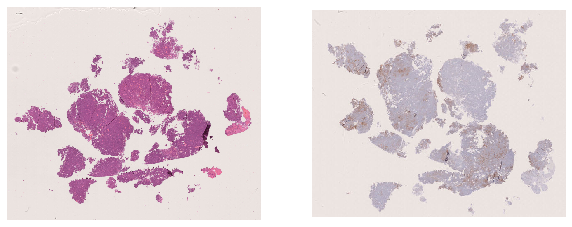

In [97]:
pair = pair_df.iloc[[45]].squeeze()
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

display_n_2d_arrays([he_pic, ihc_pic], cmap=['gray', 'gray'])

As you can see, several "islands" of tissue have been seperated in the lower portion of the HE WSI. The IHC WSI shows a similar rip, but it's not complete - two of the three "islands" are still connected to the larger tissue portions, at least in part.

The transformations we have generated so far are not fit to match WSIs like these. That's why we apply the "Divide and Conquer" strategy in cases like this one: Using Cell B, we feed two different pairs to the algorithm - one with the upper and one with the lower portion:

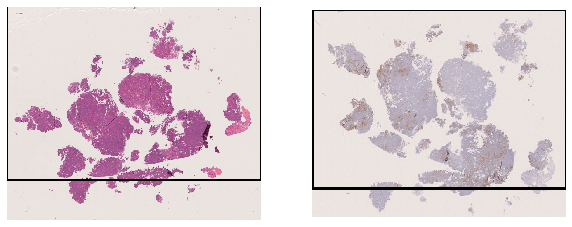

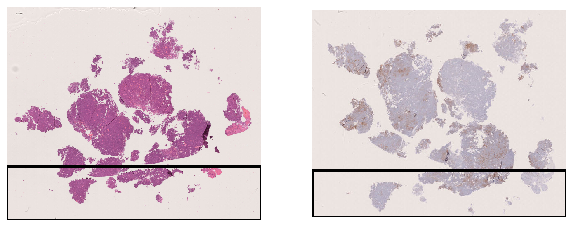

In [100]:
for index, pair in pair_df.loc[pair_df["ihc name"] == "ripp-ed-I-LH"].iterrows():
    display_n_2d_arrays([draw_rectangle(he_pic,
                                        pair["crop he left"],
                                        pair["crop he top"],
                                        he_pic.size[0]-pair["crop he right"],
                                        he_pic.size[1]-pair["crop he bottom"]),
                         draw_rectangle(ihc_pic,
                                        pair["crop ihc left"],
                                        pair["crop ihc top"],
                                        ihc_pic.size[0]-pair["crop ihc right"],
                                        ihc_pic.size[1]-pair["crop ihc bottom"])])

There were some pairs where the rip was horizontal enough for this approach to work. It is not to be expected that the algorithm will solve this registration problem though. Thus, we use a image manipulation program to modify the contrast image that the algorithm will work with instead:

Before:


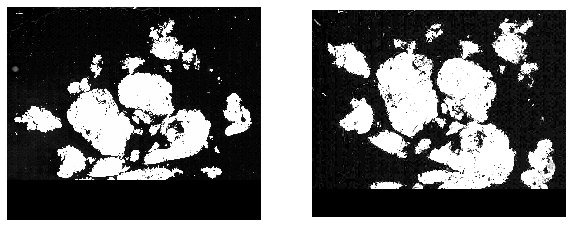

In [109]:
he_inv_contrast = get_contrast_image(he_pic)
ihc_inv_contrast = get_contrast_image(ihc_pic)

pair = pair_df.iloc[[45]].squeeze()

he_alpha = Image.new("L", he_pic.size, 0)
draw = ImageDraw.Draw(he_alpha)
draw.rectangle((pair["crop he left"],
                pair["crop he top"],
                he_pic.size[0]-pair["crop he right"],
                he_pic.size[1]-pair["crop he bottom"]
             ), fill=255)

ihc_alpha = Image.new("L", ihc_pic.size, 0)
draw = ImageDraw.Draw(ihc_alpha)
draw.rectangle((pair["crop ihc left"],
                pair["crop ihc top"],
                ihc_pic.size[0]-pair["crop ihc right"],
                ihc_pic.size[1]-pair["crop ihc bottom"]
             ), fill=255)

he_black = Image.new("L", he_pic.size, 0)
ihc_black = Image.new("L", ihc_pic.size, 0)

print("Before:")
display_n_2d_arrays([Image.composite(he_inv_contrast, he_black, he_alpha),
                     Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)])

After:


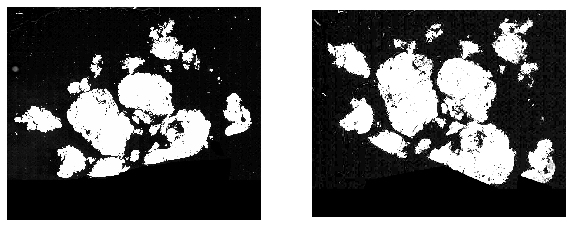

In [110]:
print("After:")
display_n_2d_arrays([Image.open(output_path/'ContrastImsEdited/45_HE.png'),
                     Image.open(output_path/'ContrastImsEdited/45_IHC.png')])

These images can now reasonably be registered.

### Code for downloading images

First of, here's a list of all these cases:

In [111]:
pair_df[(pair_df["graphic changes"] == True)]

(classified)


Now, we will edit each contrast image pair by doing the following:
- applying the contrast and cropping algorithm on both the IHC and the HE slide
- saving them as image files using descriptive names
- locally editing them (e.g., using GIMP) and saving them in a seperate folder

In [112]:
def saveGraphicChangesPNGs():
    for index, pair in pair_df[(pair_df["graphic changes"] == True)].iterrows():
        pair_ihc_name = pair["ihc name"]
        pair_he_name = pair["he name"]
        ihc_slide = slide.open_slide(pair["ihc path"])
        he_slide = slide.open_slide(pair["he path"])

        ihc_pic = ihc_slide.read_region((0,0),
                                         level,
                                         ihc_slide.level_dimensions[level])
        he_pic = he_slide.read_region((0,0),
                                     level,
                                     he_slide.level_dimensions[level])

        he_inv_contrast = get_contrast_image(he_pic)
        ihc_inv_contrast = get_contrast_image(ihc_pic)

        he_alpha = Image.new("L", he_pic.size, 0)
        draw = ImageDraw.Draw(he_alpha)
        draw.rectangle((pair["crop he left"],
                        pair["crop he top"],
                        he_pic.size[0]-pair["crop he right"],
                        he_pic.size[1]-pair["crop he bottom"]
                     ), fill=255)

        ihc_alpha = Image.new("L", ihc_pic.size, 0)
        draw = ImageDraw.Draw(ihc_alpha)
        draw.rectangle((pair["crop ihc left"],
                        pair["crop ihc top"],
                        ihc_pic.size[0]-pair["crop ihc right"],
                        ihc_pic.size[1]-pair["crop ihc bottom"]
                     ), fill=255)

        he_black = Image.new("L", he_pic.size, 0)
        ihc_black = Image.new("L", ihc_pic.size, 0)

        Image.composite(he_inv_contrast, he_black, he_alpha).save(output_path/('ContrastIms/'+str(index)+'_HE.png'))
        Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha).save(output_path/('ContrastIms/'+str(index)+'_IHC.png'))
        
# # In order not to overwrite the images later, we only want to execute this function once.
# # That's why it's commented out:
# saveGraphicChangesPNGs()

## Quality control, and numbers

Are there any pairs where "needed adjustments" is True, but no adjustments were made?

In [114]:
len(pair_df[  (pair_df["rerun"] == True)
        & (pair_df["needed adjustments"] == True)
        & (pair_df["multiple configs"] == False)
        & (pair_df["graphic changes"] == False)
        & (pair_df["rotate ihc degrees"] == 0)
        & (pair_df["crop he left"] == 0)
        & (pair_df["crop he top"] == 0)
        & (pair_df["crop he right"] == 0)
        & (pair_df["crop he bottom"] == 0)
        & (pair_df["crop ihc left"] == 0)
        & (pair_df["crop ihc top"] == 0)
        & (pair_df["crop ihc right"] == 0)
        & (pair_df["crop ihc bottom"] == 0)
       ])

0

Good.

Are there any pairs where "needed adjustments" is False, although adjustments were made?

In [116]:
len(pair_df[  (pair_df["needed adjustments"] == False)
        & (
              (pair_df["multiple configs"] == True)
            | (pair_df["graphic changes"] == True)
            | (pair_df["rotate ihc degrees"] != 0)
            | (pair_df["crop he left"] != 0)
            | (pair_df["crop he top"] != 0)
            | (pair_df["crop he right"] != 0)
            | (pair_df["crop he bottom"] != 0)
            | (pair_df["crop ihc left"] != 0)
            | (pair_df["crop ihc top"] != 0)
            | (pair_df["crop ihc right"] != 0)
            | (pair_df["crop ihc bottom"] != 0)
        )
       ])

0

Good

Of the pairs we need to rerun, how many are just a blind rerun without any alterations?

In [118]:
len(pair_df[  (pair_df["rerun"] == True)
            & (pair_df["needed adjustments"] == False)
           ])

5

→ 5

A copy of the current dataframe was made in case we will want to check any other former registration duration numbers later.

In [120]:
len(pair_df[pair_df["rotate ihc degrees"] != 0])

8

## Rerun

### Description

Here's a summarization of what we will change in this algorithm:
1. We will exclude unusable cases and only rerun "rerun" cases
2. We will use the crop values to focus on the relevant portion of each WSI
3. We will use the manually modified image files for registration in the "graphic changes" cases
4. We will initialize transformations for rotated IHC WSIs according to their rotation values
5. We will call it our second attempt, and name resulting transformation files accordingly

In our case, there are no WSIs that have to both be rotated **and** cropped. If there were, however, it would be sensible to first crop and then rotate, and to have that consistent with the algorithms in the interact cells.

In [121]:
level = 7
# we will still save transformations here:
OUTPUT_DIR_TFMS_AFF = 'Output/Transforms/1 Affines'
OUTPUT_DIR_TFMS_BSP = 'Output/Transforms/2 BSplines'

In [122]:
print(datetime.now(tz).strftime("%d.%m.%Y, %H:%M:%S"))

20.04.2023, 14:01:02


Also, in order not to lose our times from the first run, we make a backup of the current dataframe file.

Further explanations are contained within the code.

### Running the algorithm over all rerun cases

In [123]:
nth_attempt = 2

In [ ]:
def registerPairs2(df_to_reg, attemptNo):
    with open('out.txt', 'a+') as f:
        print("Starting attempt #"+str(attemptNo), file = f)

    BSP_BOUNDS = 20 # BSpline registration bounds
                    # this value ensures that the moving image isn't being deformed in the presence of rips and holes
    NUM_OF_HISTOGRAM_BINS = 10

    for index, pair in df_to_reg.iterrows():
        if pair["rerun"] == False:
            continue
        
        if pair["unusable"] == True:
            continue
            
        success = False # we will print an error later if success isn't True
        timestartThisCase = time.time() # measure time for the whole case
        
        for j in range(3): # we give each pair a maximum of three attempts before printing an error
            try:
                pair_ihc_name = pair["ihc name"]
                pair_he_name = pair["he name"]
                ihc_slide = slide.open_slide(pair["ihc path"])
                he_slide = slide.open_slide(pair["he path"])

                ihc_pic = ihc_slide.read_region((0,0),
                                                 level,
                                                 ihc_slide.level_dimensions[level])
                he_pic = he_slide.read_region((0,0),
                                             level,
                                             he_slide.level_dimensions[level])
                
                ihc_inv_contrast = get_contrast_image(ihc_pic)
                he_inv_contrast = get_contrast_image(he_pic)
                
                # Here's where "graphic changes" and our crop values come into play
                needsCropping = ((
                    pair["crop ihc left"] +
                    pair["crop ihc top"] +
                    pair["crop ihc right"] +
                    pair["crop ihc bottom"] +
                    pair["crop he left"] +
                    pair["crop he top"] +
                    pair["crop he right"] +
                    pair["crop he bottom"]) > 0)
                if pair["graphic changes"] == True:
                    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
                    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))
                    
                elif needsCropping == True:
                    he_alpha = Image.new("L", he_pic.size, 0)
                    draw = ImageDraw.Draw(he_alpha)
                    draw.rectangle((pair["crop he left"],
                                    pair["crop he top"],
                                    he_pic.size[0]-pair["crop he right"],
                                    he_pic.size[1]-pair["crop he bottom"]
                                 ), fill=255)

                    ihc_alpha = Image.new("L", ihc_pic.size, 0)
                    draw = ImageDraw.Draw(ihc_alpha)
                    draw.rectangle((pair["crop ihc left"],
                                    pair["crop ihc top"],
                                    ihc_pic.size[0]-pair["crop ihc right"],
                                    ihc_pic.size[1]-pair["crop ihc bottom"]
                                 ), fill=255)
                    he_black = Image.new("L", he_pic.size, 0)
                    ihc_black = Image.new("L", ihc_pic.size, 0)
                    
                    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
                    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

                doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
                          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
                he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
                ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
                
                # center of mass:
                he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
                he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
                ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
                ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))
                
                # our pre-registration algorithm is now concluded
                # Now let's register!
                fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
                moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

                # First, the translation
                trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
                moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
                
                trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
                registration_method = sitk.ImageRegistrationMethod()
                registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
                registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
                registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
                registration_method.SetInterpolator(sitk.sitkLinear)
                registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                                  numberOfIterations=100,
                                                                  convergenceMinimumValue=1e-6,
                                                                  convergenceWindowSize=1000)
                registration_method.SetOptimizerScalesFromPhysicalShift()
                registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
                registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
                registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
                registration_method.SetInitialTransform(trl_transform)

                # measure time
                timestart = time.time()
                registration_method.Execute(fixed_image, moving_image)
                reg_duration_ms = round((time.time() - timestart)*1000)

                pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

                # in order to continue, we need to resample our moving image
                moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
                
                # calculate similarities:
                he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
                ssim_trltd_ini = calculateSSIM(
                    he_comparison_img,
                    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
                )
                ssim_trltd = calculateSSIM(
                    he_comparison_img,
                    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
                )

                # Use only the best transformation
                aff_transform_best = trl_transform
                moving_im_best_aff = moving_im_trltd
                ssim_best_aff = ssim_trltd
                best_aff_str = "reg trl"
                if ssim_trltd_ini > ssim_trltd:
                    aff_transform_best = trl_transform_ini
                    moving_im_best_aff = moving_im_trltd_ini
                    ssim_best_aff = ssim_trltd_ini
                    best_aff_str = "initial trl"

                    
                # Secondly, register a rotation transformation.
                transform_eul = sitk.Euler2DTransform()
                transform_eul.SetTranslation(aff_transform_best.GetParameters())
                he_com_xy = (he_com_yx[1], he_com_yx[0])
                transform_eul.SetCenter(he_com_xy)
                
                # We use our rotation value now
                if pair["rotate ihc degrees"] != 0: 
                    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
                    transform_eul.SetAngle(angle_as_pi)

                # Note that we don't use `sitk.CenteredTransformInitializer`.
                # It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
                registration_method = sitk.ImageRegistrationMethod()
                registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
                registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
                registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
                registration_method.SetInterpolator(sitk.sitkLinear)
                registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                                  numberOfIterations=100,
                                                                  convergenceMinimumValue=1e-6,
                                                                  convergenceWindowSize=1000)
                registration_method.SetOptimizerScalesFromPhysicalShift()
                registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
                registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
                registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
                registration_method.SetInitialTransform(transform_eul)

                # measure time
                timestart = time.time()
                registration_method.Execute(fixed_image, moving_image)
                reg_duration_ms = round((time.time() - timestart)*1000)

                pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

                # again, we need to resample our moving image
                moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

                # calculate similarities:
                ssim_euld = calculateSSIM(
                    he_comparison_img,
                    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
                )

                # Use only the best transformation
                best_aff_is_trl = True
                if ssim_euld > ssim_best_aff:
                    aff_transform_best = transform_eul
                    moving_im_best_aff = moving_im_euld
                    ssim_best_aff = ssim_euld
                    best_aff_is_trl = False
                    best_aff_str = "reg eul"


                # Thirdly, register an affine transformation
                transform_aff = sitk.AffineTransform(2)
                transform_aff.SetCenter(he_com_xy)
                if best_aff_is_trl:
                    transform_aff.SetTranslation(aff_transform_best.GetParameters())
                    # We use our rotation value again, since we don't use the euler tfm as our template
                    if pair["rotate ihc degrees"] != 0: 
                        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
                        transform_aff.SetAngle(angle_as_pi)
                else:
                    if hasattr(aff_transform_best,"GetMatrix"):
                        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
                    if hasattr(aff_transform_best,"GetTranslation"):
                        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
                    if hasattr(aff_transform_best,"GetCenter"):
                        transform_aff.SetCenter(aff_transform_best.GetCenter())

                registration_method = sitk.ImageRegistrationMethod()
                registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
                registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
                registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
                registration_method.SetInterpolator(sitk.sitkLinear)
                registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                                  numberOfIterations=100,
                                                                  convergenceMinimumValue=1e-6,
                                                                  convergenceWindowSize=1000)
                registration_method.SetOptimizerScalesFromPhysicalShift()
                registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
                registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
                registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
                registration_method.SetInitialTransform(transform_aff)

                # measure time
                timestart = time.time()
                registration_method.Execute(fixed_image, moving_image)
                reg_duration_ms = round((time.time() - timestart)*1000)

                pair_df.loc[index, 'aff registration duration'] = reg_duration_ms
                
                # again, we need to resample our moving image
                moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

                # calculate similarities:
                ssim_affd = calculateSSIM(
                    he_comparison_img,
                    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
                )

                # Use only the best transformation
                if ssim_affd > ssim_best_aff:
                    aff_transform_best = transform_aff
                    moving_im_best_aff = moving_im_affd
                    best_aff_str = "reg aff"
                
                # save the best affine transformation
                aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
                sitk.WriteTransform(aff_transform_best, aff_path)
                
                pair_df.loc[index, 'aff path'] = aff_path
                pair_df.loc[index, 'best aff tfm'] = best_aff_str



                # Finally, the BSpline transformation.
                # This nonlinear transformation helps close the gap between the moving and the fixed image.
                # Small incongruences are straightened out.
                transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
                tx = sitk.BSplineTransformInitializer(fixed_image,
                                                      transformDomainMeshSize)
                R = sitk.ImageRegistrationMethod()
                R.SetMetricAsCorrelation()
                R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                                       numberOfIterations=150,
                                       maximumNumberOfCorrections=5,
                                       maximumNumberOfFunctionEvaluations=1000,
                                       costFunctionConvergenceFactor=1e+10,
                                       lowerBound = -1*BSP_BOUNDS,
                                       upperBound = BSP_BOUNDS)
                R.SetInitialTransform(tx, True)
                R.SetInterpolator(sitk.sitkLinear)

                # measure time
                timestart = time.time()
                outTx = R.Execute(fixed_image, moving_im_best_aff)
                reg_duration_ms = round((time.time() - timestart)*1000)

                # save the bspline transform
                bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
                sitk.WriteTransform(outTx, bsp_path)

                pair_df.loc[index, 'bsp path'] = bsp_path
                pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms
                
                pair_df.loc[index, 'attempts'] = attemptNo
                success = True

                with open('out.txt', 'a+') as f:
                    print(datetime.now(tz).strftime("%d.%m.%Y, %H:%M:%S") + ': index ' + str(index) + ' successful', file=f)  # Python 3.x
                break
            except:
                # if an error is thrown, we want to log it together with a timestamp and the index
                with open('out.txt', 'a+') as f:
                    print(datetime.now(tz).strftime("%d.%m.%Y, %H:%M:%S") + ': index ' + str(index) + ' error' + str(j) + ':', file=f)  # Python 3.x
                    print(sys.exc_info()[0], file=f)
                continue
        if not success:
            # after three attempts, log this message:
            with open('out.txt', 'a+') as f:
                print(datetime.now(tz).strftime("%d.%m.%Y, %H:%M:%S") + ': PROBLEM WITH INDEX ' + str(index) + ", MOVING ON", file=f)  # Python 3.x
        
        # save the time everything took:
        full_duration_ms = round((time.time() - timestartThisCase)*1000)
        pair_df.loc[index, 'full duration'] = full_duration_ms

        # finally, save our pair_df-changes
        pair_df.to_csv(output_path/'pairlist_df_3-3-4.csv', index=False)
                
# # This code is commented out because we only want to execute it once.
# # Also, make sure the attemptNo (2nd parameter) is correct
# registerPairs2(pair_df, nth_attempt)

### Looking at the rerun's results: Cell A again

First of, let's set `rerun` to False again, in case we need to tag some cases again with this label. We will still know which cases have been rerun, since we also have the `attempts` column.

In [125]:
# # Only to be executed once:
# pair_df = pair_df.assign(rerun=False)
# # and save:
# pair_df.to_csv(output_path/'pairlist_df_3-3-4.csv', index=False)

Now, we will look at the new results, in an interactive cell similar to the one we used before.

#### Code for Interact Cell A

In [220]:
second_index = 0
global_index = pair_df.loc[((pair_df["attempts"] == nth_attempt))].index[second_index]

MAX_2ND_IND = len(pair_df.loc[((pair_df["attempts"] == nth_attempt))])-1

# reminder: the level of detail we use is still 7
level = 7

In [221]:
callback_After_Iteration = None
def iterate2ndAndClose(increment):
    global global_index, second_index, callback_After_Iteration
    second_index += increment
    global_index = pair_df.loc[((pair_df["attempts"] == nth_attempt))].index[second_index]
    clear_output()
    print("current index is now "+str(global_index))
    if callback_After_Iteration != None:
        callback_After_Iteration()
    else:
        print("please re-run this cell")
        
def inc2ndAndClose(button):
    iterate2ndAndClose(1)
def dec2ndAndClose(button):
    iterate2ndAndClose(-1)
    
def tag_rerun(button):
    global global_index, pair_df
    pair_df.loc[global_index, 'rerun'] = True
    pair_df.to_csv(output_path/'pairlist_df_3-3-4.csv', index=False)
    print("pair was tagged for rerun")

# we won't need the other buttons

For Interact Cell A, we need both the fixed and the moving image (transformed).
To make the code faster, let's transform the ihc image only in greyscale here.

In [128]:
def loadAndShowPair():
    pair = pair_df.iloc[[global_index]].squeeze()

    pair_ihc_name = pair["ihc name"]
    pair_he_name = pair["he name"]
    ihc_slide = slide.open_slide(pair["ihc path"])
    he_slide = slide.open_slide(pair["he path"])

    ihc_pic = ihc_slide.read_region((0,0),
                                     level,
                                     ihc_slide.level_dimensions[level])
    he_pic = he_slide.read_region((0,0),
                                 level,
                                 he_slide.level_dimensions[level])
    ihc_grey = ihc_pic.convert('L')
    doublesize = (2*max(he_pic.size[0], ihc_pic.size[0]),
              2*max(he_pic.size[1], ihc_pic.size[1]))
    he_pic = he_pic.crop([0,0,doublesize[0],doublesize[1]])
    ihc_grey = ihc_grey.crop([0,0,doublesize[0],doublesize[1]])

    moving_image = sitk.GetImageFromArray(np.array(ihc_grey).astype('float32'))
    composite = sitk.CompositeTransform([sitk.ReadTransform(pair["aff path"]), sitk.ReadTransform(pair["bsp path"])])
    moving_image_tfmd = sitk.Resample(moving_image, composite, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    moving_image_affd = sitk.Resample(moving_image, sitk.ReadTransform(pair["aff path"]), sitk.sitkLinear, 0.0, moving_image.GetPixelID())

    displayArr = [he_pic,
                  Image.fromarray(sitk.GetArrayViewFromImage(moving_image_tfmd)),
                  Image.fromarray(sitk.GetArrayViewFromImage(moving_image_affd)),
#                   he_pic,
                  ihc_grey]
    
    w_up = widgets.Button(description='v')
    w_down = widgets.Button(description='ʌ')
    w_up.on_click(inc2ndAndClose)
    w_down.on_click(dec2ndAndClose)
    
    w_rerun = widgets.Button(description='tag for rerun')
    w_rerun.on_click(tag_rerun)

    print(
#         "index: " + str(global_index) + "\n" +
        pair_ihc_name + "\n" + pair_he_name)

    interact(displayAlternating,
             imArr =  fixed(displayArr),
             displayslider = (0,len(displayArr)-1,1))
    
    if second_index != MAX_2ND_IND:
        display(w_up)
    
    if second_index != 0:
        display(w_down)
    
    display(w_rerun)

#### Interact Cell A

In [129]:
second_index = 0

Save changes to file (this also happens automatically with every change).

In [130]:
pair_df.to_csv(output_path/'pairlist_df_3-3-4.csv', index=False)

In [131]:
callback_After_Iteration = loadAndShowPair
loadAndShowPair()

(classified)


# The last remaining cases

Even after the second attempt, some cases could not be automatically registered. We will look at these cases now, register them manually, and keep a look at the time.

## Simple rerun cases

Here, we will look at cases where no adjusments were made:

In [132]:
pair_df[((pair_df["rerun"] == True) & (pair_df["needed adjustments"] == False))]

(classified)


### Case 452

It is now 1:40pm

In [291]:
index = 452
pair = pair_df[pair_df.index == 452].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [282]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

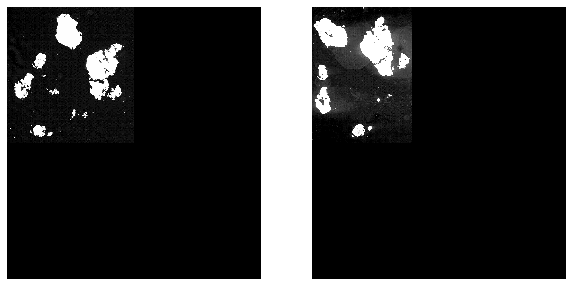

In [283]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

Understandable. Let's do something about the contrast.

In [286]:
ihc_inv_contrast = get_contrast_image(ihc_pic)
ihc_inv_contrast = get_contrast_image(ihc_inv_contrast) # just rerun
ihc_inv_contrast = get_contrast_image(ihc_inv_contrast) # just rerun
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,ihc_black.size[0],ihc_black.size[1]])
ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

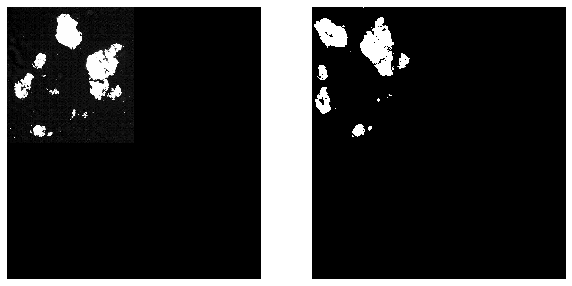

In [287]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

And since that's not enough, let's also manually add a rotation:

In [301]:
pair["rotate ihc degrees"] = -45

Before we overwrite anything, we've backed the csv file up once more.

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [303]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [326]:
pair_df.loc[452, "rotate ihc degrees"] = -45
pair_df[pair_df.index == 452]

(classified)


It's now 2:00pm. We needed 20 minutes.

In [462]:
# save the time everything took:
full_duration_ms = 20*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [307]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case 519

It is now 2:05pm

In [308]:
index = 519
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [309]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

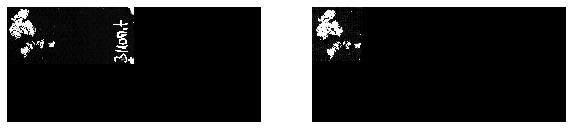

In [310]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

This stuff had not been cropped out? Oh man, that explains it. Time to execute Cell B again.

In [311]:
global_index = index

*executing Cell B above*

Let's do that again!

In [317]:
index = 519
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [318]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

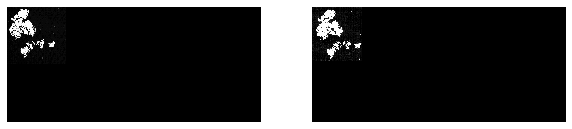

In [319]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [321]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [327]:
pair_df[pair_df.index == index]

(classified)


It's now 2:10pm. We needed 5 minutes.

In [463]:
# save the time everything took:
full_duration_ms = 5*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [324]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case 600

It is now 2:11pm

In [325]:
index = 600
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [326]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

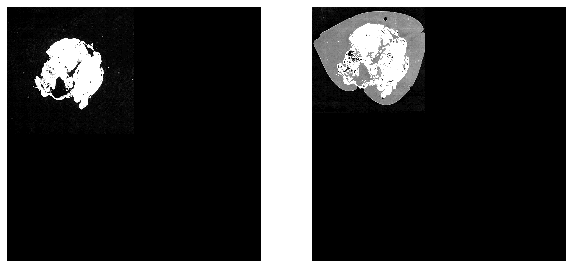

In [327]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

An understandable problem. We'll have to work the contrast of the IHC image out.

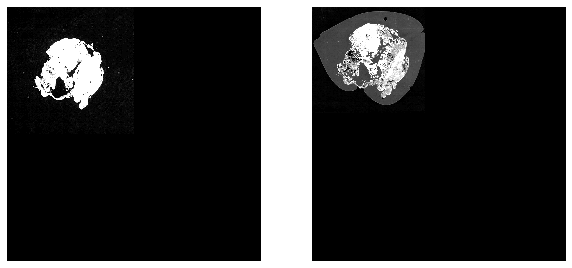

In [339]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=-3) # set to -3
        ).enhance(3),
    cutoff=5)

ihc_inv_contrast = get_contrast_image_modified(ihc_pic)

ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

Another try then!

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [341]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [342]:
pair_df[pair_df.index == index]

(classified)


It's now 2:16pm. We needed 6 minutes.

In [464]:
# save the time everything took:
full_duration_ms = 6*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [344]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### (Untag "rerun")

In [348]:
pair_df.loc[pair_df["attempts"]==3, "rerun"] = False
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

## Adjustment cases

Let's look at the other cases we worked with:

In [349]:
pair_df[pair_df["rerun"]==True]

(classified)


They are mostly "multiple config" cases, in part also simple crop cases. Let's look at them.

### Case 444

It is now 2:21pm.

In [350]:
index = 444
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [369]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

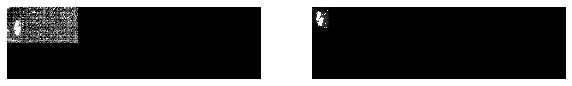

In [370]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

Ah yes, a contrast problem again.

In [393]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=1)
        ).enhance(1),
    cutoff=1)

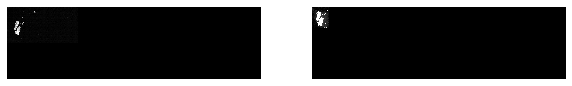

In [394]:
ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image_modified(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concludedihc_inv_contrast = get_contrast_image(ihc_pic)

display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

Also, this:

In [395]:
he_com_yx

(157, 202)

In [396]:
ihc_com_yx

(93, 69)

In [385]:
NUM_OF_HISTOGRAM_BINS = 100

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [402]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [403]:
pair_df[pair_df.index == index]

(classified)


It's now 2:34pm. We needed 13 minutes.

In [469]:
# save the time everything took:
full_duration_ms = 13*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [405]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  446

It is now 2:35pm.

In [406]:
index = 446
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [407]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

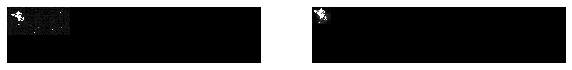

In [408]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [409]:
he_com_yx

(95, 183)

In [410]:
ihc_com_yx

(59, 70)

The center of mass is off. Let's fix that:

In [415]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=3)
        ).enhance(1),
    cutoff=3)

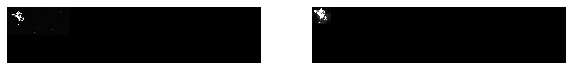

In [416]:
ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image_modified(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concludedihc_inv_contrast = get_contrast_image(ihc_pic)

display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [417]:
he_com_yx

(86, 156)

In [418]:
ihc_com_yx

(59, 70)

In [419]:
NUM_OF_HISTOGRAM_BINS = 100

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [421]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [422]:
pair_df[pair_df.index == index]

(classified)


It's now 2:38pm. We needed 3 minutes.

In [468]:
# save the time everything took:
full_duration_ms = 3*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [424]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  467

It is now 2:39pm.

In [425]:
index = 467
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [426]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

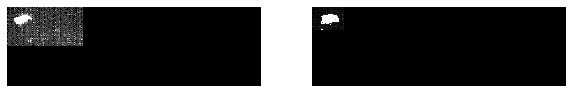

In [427]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [428]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=3)
        ).enhance(1),
    cutoff=3)

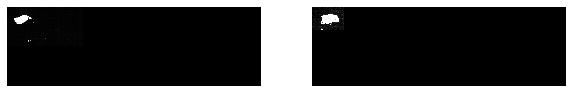

In [429]:
ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image_modified(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concludedihc_inv_contrast = get_contrast_image(ihc_pic)

display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [431]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [432]:
pair_df[pair_df.index == index]

(classified)


It's still 2:39pm. We needed 0.5 minutes.

In [467]:
# save the time everything took:
full_duration_ms = 30*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [434]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  523

It is now 2:40pm.

In [435]:
index = 523
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [436]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

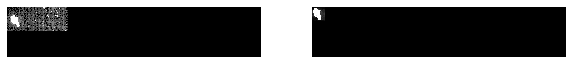

In [437]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [438]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=3)
        ).enhance(1),
    cutoff=3)

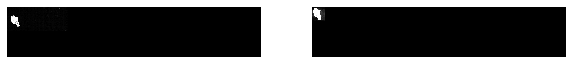

In [439]:
ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image_modified(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concludedihc_inv_contrast = get_contrast_image(ihc_pic)

display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [441]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [442]:
pair_df[pair_df.index == index]

(classified)


It's still 2:40pm. We needed 0.5 minutes.

In [466]:
# save the time everything took:
full_duration_ms = 30*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [444]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  525

It is now 2:41pm.

In [445]:
index = 525
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [446]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

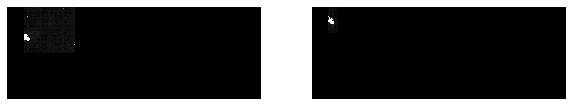

In [447]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [448]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=3)
        ).enhance(1),
    cutoff=3)

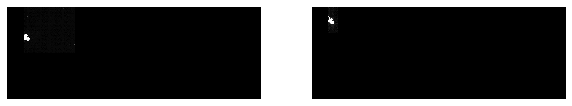

In [449]:
ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image_modified(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concludedihc_inv_contrast = get_contrast_image(ihc_pic)

display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [452]:
NUM_OF_HISTOGRAM_BINS = 100

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [454]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [455]:
pair_df[pair_df.index == index]

(classified)


It's 2:41pm. We needed 1 minute.

In [465]:
# save the time everything took:
full_duration_ms = 1*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [460]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  526

It is now 2:52pm.

In [471]:
index = 526
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [472]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

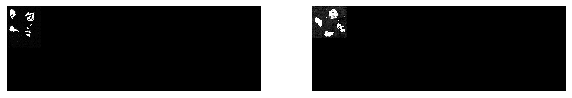

In [473]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [476]:
pair["rotate ihc degrees"] = -30

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [478]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [479]:
pair_df.loc[index, "rotate ihc degrees"] = -30
pair_df[pair_df.index == index]

(classified)


It's 2:54pm. We needed 2 minutes.

In [480]:
# save the time everything took:
full_duration_ms = 2*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [481]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  573

It is now 2:55pm.

In [482]:
index = 573
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [483]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

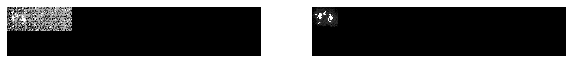

In [484]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [495]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=1)
        ).enhance(1),
    cutoff=1)

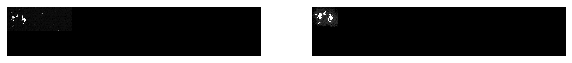

In [496]:
ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image_modified(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concludedihc_inv_contrast = get_contrast_image(ihc_pic)

display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [497]:
NUM_OF_HISTOGRAM_BINS = 100

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [499]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [500]:
pair_df[pair_df.index == index]

(classified)


It's 2:57pm. We needed 2 minutes.

In [501]:
# save the time everything took:
full_duration_ms = 2*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [502]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  619

It is now 2:58pm.

In [503]:
index = 619
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [504]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

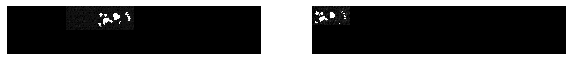

In [505]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [506]:
he_com_yx

(105, 881)

In [507]:
ihc_com_yx

(88, 154)

In [508]:
NUM_OF_HISTOGRAM_BINS = 100

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [510]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [511]:
pair_df[pair_df.index == index]

(classified)


It's 2:59pm. We needed 1 minute.

In [512]:
# save the time everything took:
full_duration_ms = 1*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [513]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  634

It is now 3:00pm.

In [514]:
index = 634
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [515]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

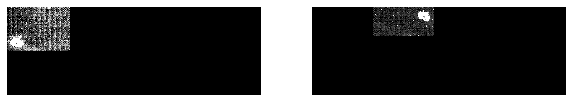

In [516]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [526]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=2)
        ).enhance(1),
    cutoff=2)

In [534]:
def get_contrast_image_modified2(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=1)
        ).enhance(1),
    cutoff=1)

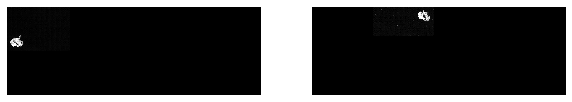

In [535]:
ihc_inv_contrast = get_contrast_image_modified(ihc_pic)
he_inv_contrast = get_contrast_image_modified2(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [536]:
NUM_OF_HISTOGRAM_BINS = 100

In [537]:
he_com_yx

(171, 110)

In [546]:
he_com_yx = (180,5)

In [547]:
ihc_com_yx

(67, 587)

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [549]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [550]:
pair_df[pair_df.index == index]

(classified)


It's 2:59pm. We needed 5 minutes.

In [551]:
# save the time everything took:
full_duration_ms = 5*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [552]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  635

It is now 3:06pm.

In [553]:
index = 635
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [554]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

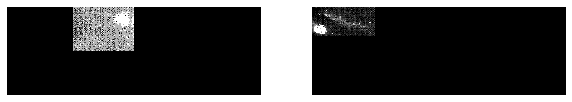

In [555]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [556]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=2)
        ).enhance(1),
    cutoff=2)

In [557]:
def get_contrast_image_modified2(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=1)
        ).enhance(1),
    cutoff=1)

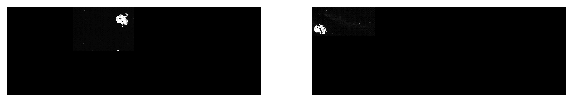

In [558]:
ihc_inv_contrast = get_contrast_image_modified(ihc_pic)
he_inv_contrast = get_contrast_image_modified2(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [559]:
NUM_OF_HISTOGRAM_BINS = 100

In [560]:
he_com_yx

(97, 615)

In [564]:
he_com_yx = (60,615)

In [561]:
ihc_com_yx

(107, 108)

In [565]:
ihc_com_yx = (107, 20)

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [567]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [568]:
pair_df[pair_df.index == index]

(classified)


It's 3:08pm. We needed 2 minutes.

In [569]:
# save the time everything took:
full_duration_ms = 2*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [570]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  640

It is now 3:09pm.

In [571]:
index = 640
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [572]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

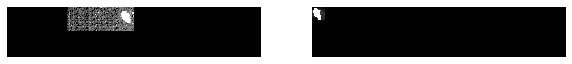

In [573]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [574]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=2)
        ).enhance(1),
    cutoff=2)

In [580]:
def get_contrast_image_modified2(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=1)
        ).enhance(1),
    cutoff=1)

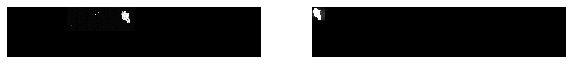

In [581]:
ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image_modified2(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [582]:
NUM_OF_HISTOGRAM_BINS = 100

In [583]:
he_com_yx

(94, 914)

In [584]:
ihc_com_yx

(63, 48)

In [590]:
he_com_yx = (75,880)

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [592]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [593]:
pair_df[pair_df.index == index]

(classified)


It's 3:12pm. We needed 3 minutes.

In [594]:
# save the time everything took:
full_duration_ms = 3*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [595]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  642

It is now 3:14pm.

In [596]:
index = 642
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [597]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

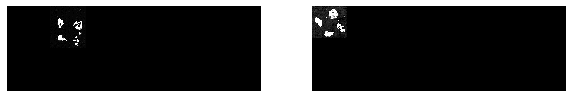

In [598]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [599]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=2)
        ).enhance(1),
    cutoff=2)

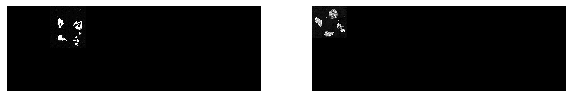

In [600]:
ihc_inv_contrast = get_contrast_image_modified(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [601]:
NUM_OF_HISTOGRAM_BINS = 100

In [602]:
pair["rotate ihc degrees"] = -30

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [604]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [605]:
pair_df.loc[index, "rotate ihc degrees"] = -30
pair_df[pair_df.index == index]

(classified)


It's 3:15pm. We needed 1 minute.

In [606]:
# save the time everything took:
full_duration_ms = 1*60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [607]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Case  664

It is now 3:16pm.

In [608]:
index = 664
pair = pair_df[pair_df.index == index].squeeze()
attemptNo = 3
NUM_OF_HISTOGRAM_BINS = 10
BSP_BOUNDS = 20

In [609]:
pair_ihc_name = pair["ihc name"]
pair_he_name = pair["he name"]
ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

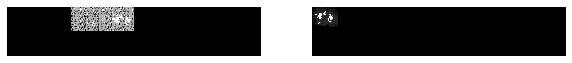

In [610]:
display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [611]:
def get_contrast_image_modified(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=2)
        ).enhance(1),
    cutoff=2)

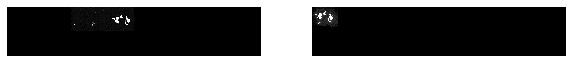

In [612]:
ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image_modified(he_pic)

# Here's where "graphic changes" and our crop values come into play
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)
if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))

elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
          2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

# center of mass:
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

# our pre-registration algorithm is now concluded

display_n_2d_arrays([he_inv_contrast, ihc_inv_contrast])

In [613]:
NUM_OF_HISTOGRAM_BINS = 100

In [614]:
he_com_yx

(105, 881)

In [615]:
ihc_com_yx

(85, 114)

Should work now

In [ ]:
# Now let's register!
fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast).astype('float32'))

# First, the translation
trl_transform_ini = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_im_trltd_ini = sitk.Resample(moving_image, trl_transform_ini, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

trl_transform = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, 
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(trl_transform)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'trl registration duration'] = reg_duration_ms

# in order to continue, we need to resample our moving image
moving_im_trltd = sitk.Resample(moving_image, trl_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
he_comparison_img = he_inv_contrast.crop((0,0,he_pic.size[0], he_pic.size[1]))
ssim_trltd_ini = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd_ini)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)
ssim_trltd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_trltd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
aff_transform_best = trl_transform
moving_im_best_aff = moving_im_trltd
ssim_best_aff = ssim_trltd
best_aff_str = "reg trl"
if ssim_trltd_ini > ssim_trltd:
    aff_transform_best = trl_transform_ini
    moving_im_best_aff = moving_im_trltd_ini
    ssim_best_aff = ssim_trltd_ini
    best_aff_str = "initial trl"


# Secondly, register a rotation transformation.
transform_eul = sitk.Euler2DTransform()
transform_eul.SetTranslation(aff_transform_best.GetParameters())
he_com_xy = (he_com_yx[1], he_com_yx[0])
transform_eul.SetCenter(he_com_xy)

# We use our rotation value now
if pair["rotate ihc degrees"] != 0: 
    angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
    transform_eul.SetAngle(angle_as_pi)

# Note that we don't use `sitk.CenteredTransformInitializer`.
# It seemed to not do what we excpected, i.e., it didn't use the translation of the inital_transform parameter)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_eul)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'eul registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_euld = sitk.Resample(moving_image, transform_eul, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_euld = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_euld)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
best_aff_is_trl = True
if ssim_euld > ssim_best_aff:
    aff_transform_best = transform_eul
    moving_im_best_aff = moving_im_euld
    ssim_best_aff = ssim_euld
    best_aff_is_trl = False
    best_aff_str = "reg eul"


# Thirdly, register an affine transformation
transform_aff = sitk.AffineTransform(2)
transform_aff.SetCenter(he_com_xy)
if best_aff_is_trl:
    transform_aff.SetTranslation(aff_transform_best.GetParameters())
    # We use our rotation value again, since we don't use the euler tfm as our template
    if pair["rotate ihc degrees"] != 0: 
        angle_as_pi = 2*np.pi*pair["rotate ihc degrees"]/360 # deg ccw to rad ccw
        transform_aff.SetAngle(angle_as_pi)
else:
    if hasattr(aff_transform_best,"GetMatrix"):
        transform_aff.SetMatrix(aff_transform_best.GetMatrix())
    if hasattr(aff_transform_best,"GetTranslation"):
        transform_aff.SetTranslation(aff_transform_best.GetTranslation())
    if hasattr(aff_transform_best,"GetCenter"):
        transform_aff.SetCenter(aff_transform_best.GetCenter())

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=NUM_OF_HISTOGRAM_BINS)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.1, 42) # seed is 42
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01,
                                                  numberOfIterations=100,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=1000)
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.SetInitialTransform(transform_aff)

# measure time
timestart = time.time()
registration_method.Execute(fixed_image, moving_image)
reg_duration_ms = round((time.time() - timestart)*1000)

pair_df.loc[index, 'aff registration duration'] = reg_duration_ms

# again, we need to resample our moving image
moving_im_affd = sitk.Resample(moving_image, transform_aff, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# calculate similarities:
ssim_affd = calculateSSIM(
    he_comparison_img,
    Image.fromarray(sitk.GetArrayViewFromImage(moving_im_affd)).crop((0,0,he_pic.size[0], he_pic.size[1]))
)

# Use only the best transformation
if ssim_affd > ssim_best_aff:
    aff_transform_best = transform_aff
    moving_im_best_aff = moving_im_affd
    best_aff_str = "reg aff"

# save the best affine transformation
aff_path = os.path.join(OUTPUT_DIR_TFMS_AFF, str(index)+"_"+pair_ihc_name + '_a' + str(attemptNo)+'.tfm') # a for affine, 1 for 1st try
sitk.WriteTransform(aff_transform_best, aff_path)

pair_df.loc[index, 'aff path'] = aff_path
pair_df.loc[index, 'best aff tfm'] = best_aff_str



# Finally, the BSpline transformation.
# This nonlinear transformation helps close the gap between the moving and the fixed image.
# Small incongruences are straightened out.
transformDomainMeshSize=[8]*moving_im_best_aff.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed_image,
                                      transformDomainMeshSize)
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-8,
                       numberOfIterations=150,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+10,
                       lowerBound = -1*BSP_BOUNDS,
                       upperBound = BSP_BOUNDS)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

# measure time
timestart = time.time()
outTx = R.Execute(fixed_image, moving_im_best_aff)
reg_duration_ms = round((time.time() - timestart)*1000)

# save the bspline transform
bsp_path = os.path.join(OUTPUT_DIR_TFMS_BSP, str(index)+"_"+pair_ihc_name + '_b' + str(attemptNo)+'.tfm') # b for bspline, 1 for 1st try
sitk.WriteTransform(outTx, bsp_path)

pair_df.loc[index, 'bsp path'] = bsp_path
pair_df.loc[index, 'bsp registration duration'] = reg_duration_ms

pair_df.loc[index, 'attempts'] = attemptNo

Let's check out the result:

In [617]:
moving_im_tfmd = sitk.Resample(moving_im_best_aff, outTx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
displayArr = [Image.fromarray(sitk.GetArrayViewFromImage(fixed_image)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_tfmd)),
              Image.fromarray(sitk.GetArrayViewFromImage(moving_im_best_aff)),
#                   he_pic
             ]

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=2), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

In [618]:
pair_df[pair_df.index == index]

(classified)


It's 3:17pm. We needed 1 minute.

In [619]:
# save the time everything took:
full_duration_ms = 60*1000
pair_df.loc[index, 'full duration'] = full_duration_ms

In [620]:
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### (Untag "rerun")

In [621]:
pair_df.loc[pair_df["attempts"]==3, "rerun"] = False
pair_df.to_csv(output_path/'pairlist_df_3.csv', index=False)

### Durations

In [22]:
durs = [
    13,
    3,
    0.5,
    0.5,
    1,
    2,
    2,
    1,
    5,
    2,
    3,
    1,
    1
]

In [30]:
sum(durs[1:]) / len(durs[1:])

1.8333333333333333

# Code for the paper

## Outline algorithm

In [ ]:
from PIL import ImageFilter

In [ ]:
from PIL import ImageEnhance

blaa = ihc_tfmd_wob.convert("L")

#image brightness enhancer
enhancer = ImageEnhance.Contrast(blaa)

factor = 1.5 #increase contrast
enhancer.enhance(factor)

In [ ]:
outlineimg = enhancer.enhance(10).filter(ImageFilter.FIND_EDGES)
outlineimg

## Measuring similarities

### Stragegy

We want the following values:
- MSE
- SSIM without a set window size
- SSIM with the highest possible window size
- correlation
- Mattes MI

We want them of the following pairs:
- similarity of pair, transformed using center of mass, cropped to HE size (after rotations and manual croppings, if needed)
- similarity after affine
- similarity after bspline

And we want them rounded to 4 digits after the comma

In [32]:
import pathlib
from pathlib import Path
output_path = Path('Output')

import pandas as pd

pair_df = pd.read_csv(output_path/'pairlist_df_3-Copy_FINAL_2023-04-06.csv')

### Prerequesite functions

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

simdict = {}

In [34]:
import scipy.ndimage as ndi

In [35]:
def display_n_2d_arrays(imagelist, fig_size=None, cmap=[], titles=[]):
    n = len(imagelist)
    if len(cmap) != n:
        cmap = n*['gray']
    if len(titles) != n:
        titles = n*['']
    if fig_size == None:
        fig_size = ((int)(n*5),8)
    plt.subplots(1,n,figsize=fig_size)
    
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(imagelist[i], cmap[i], vmin=0, vmax=255)
        plt.axis('off')
        plt.title(titles[i])
    
    plt.show()

In [36]:
from PIL import ImageEnhance
import PIL.ImageOps
def get_contrast_image(rgb_image):
    return PIL.ImageOps.autocontrast(
        ImageEnhance.Brightness(
            PIL.ImageOps.autocontrast(
                Image.fromarray(
                    np.array(
                        PIL.ImageOps.invert(
                            rgb_image.convert('L')
                        )
                    ).astype('uint8'), mode='L'),
            cutoff=1)
        ).enhance(3),
    cutoff=5)

In [37]:
def getCorrelation(im1, im2):
    tempReg = sitk.ImageRegistrationMethod()
    tempReg.SetMetricAsCorrelation()
    dimension = 2
    tempReg.SetInitialTransform(sitk.Transform(dimension, sitk.sitkIdentity), True)
    fixedTestIm = sitk.GetImageFromArray(np.array(im1).astype('float32'))
    movingTestIm = sitk.GetImageFromArray(np.array(im2).astype('float32'))
    return tempReg.MetricEvaluate(fixedTestIm, movingTestIm)
def getMattes(im1, im2, histoNum=1000):
    tempReg = sitk.ImageRegistrationMethod()
    tempReg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=histoNum)
    registration_method = sitk.ImageRegistrationMethod()
    tempReg.SetMetricSamplingStrategy(registration_method.REGULAR)
    tempReg.SetMetricSamplingPercentage(0.1, 42) # seed is 42, percentage value seems to be irrelevant
    dimension = 2
    tempReg.SetInitialTransform(sitk.Transform(dimension, sitk.sitkIdentity), True)
    fixedTestIm = sitk.GetImageFromArray(np.array(im1).astype('float32'))
    movingTestIm = sitk.GetImageFromArray(np.array(im2).astype('float32'))
    return tempReg.MetricEvaluate(fixedTestIm, movingTestIm)

In [38]:
metricList = ["mse", "ssim_winNone", "ssim_winmax", "correlation", "MattesMI"]
def calculateMetrics(im1, im2, targetDict, stage):
    for met in metricList:
        if not met in targetDict:
            targetDict[met] = {}
    im1Weird = np.array(im1.convert('L')).astype(float)/255
    im2Weird = np.array(im2.convert('L')).astype(float)/255
    targetDict["mse"][stage] = round(mean_squared_error(im1Weird, im2Weird), 4)
    targetDict["ssim_winNone"][stage] = round(ssim(im1Weird, im2Weird, win_size=None), 4)
    
    maxwinsize = min(im1.size[0], im1.size[1])
    if maxwinsize%2==0:
        maxwinsize -= 1
    targetDict["ssim_winmax"][stage] = round(ssim(im1Weird, im2Weird, win_size=maxwinsize), 4)
    
    targetDict["correlation"][stage] = round(getCorrelation(im1, im2), 4)
    
    targetDict["MattesMI"][stage] = round(getMattes(im1, im2), 4)

### Implementation by example

In [40]:
index = 507
level = 7
pair = pair_df.iloc[[index]].squeeze()

ihc_slide = slide.open_slide(pair["ihc path"])
he_slide = slide.open_slide(pair["he path"])

ihc_pic = ihc_slide.read_region((0,0),
                                 level,
                                 ihc_slide.level_dimensions[level])
he_pic = he_slide.read_region((0,0),
                             level,
                             he_slide.level_dimensions[level])

ihc_inv_contrast = get_contrast_image(ihc_pic)
he_inv_contrast = get_contrast_image(he_pic)
needsCropping = ((
    pair["crop ihc left"] +
    pair["crop ihc top"] +
    pair["crop ihc right"] +
    pair["crop ihc bottom"] +
    pair["crop he left"] +
    pair["crop he top"] +
    pair["crop he right"] +
    pair["crop he bottom"]) > 0)

if pair["graphic changes"] == True:
    ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
    he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))
elif needsCropping == True:
    he_alpha = Image.new("L", he_pic.size, 0)
    draw = ImageDraw.Draw(he_alpha)
    draw.rectangle((pair["crop he left"],
                    pair["crop he top"],
                    he_pic.size[0]-pair["crop he right"],
                    he_pic.size[1]-pair["crop he bottom"]
                 ), fill=255)

    ihc_alpha = Image.new("L", ihc_pic.size, 0)
    draw = ImageDraw.Draw(ihc_alpha)
    draw.rectangle((pair["crop ihc left"],
                    pair["crop ihc top"],
                    ihc_pic.size[0]-pair["crop ihc right"],
                    ihc_pic.size[1]-pair["crop ihc bottom"]
                 ), fill=255)
    he_black = Image.new("L", he_pic.size, 0)
    ihc_black = Image.new("L", ihc_pic.size, 0)

    he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
    ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
              2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
he_inv_contrast_ds = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
ihc_inv_contrast_ds = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast_ds).astype('float32'))
moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast_ds).astype('float32'))

# let's measure the similarity after the initial transform first
he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

trl_transform_1 = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
moving_image_trltd_1 = sitk.Resample(moving_image, trl_transform_1, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
moving_im_trltd_1_pil = Image.fromarray(sitk.GetArrayViewFromImage(moving_image_trltd_1))

simdict[index] = {}

he_bbox = he_inv_contrast.getbbox()
ihc_bboxed_1 = moving_im_trltd_1_pil.crop(he_bbox)
he_bboxed = he_inv_contrast.crop(he_bbox)#.convert('F') # has type 'L', but that doesn't change the metrics, so whatever
calculateMetrics(he_bboxed, ihc_bboxed_1, simdict[index], "1: CoM translated")

aff_tfm = sitk.ReadTransform(pair["aff path"])
moving_image_aff = sitk.Resample(moving_image, aff_tfm, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
moving_im_aff_pil = Image.fromarray(sitk.GetArrayViewFromImage(moving_image_aff))
ihc_bboxed_2 = moving_im_aff_pil.crop(he_bbox)
calculateMetrics(he_bboxed, ihc_bboxed_2, simdict[index], "2: Affine transformed")

bsp_tfm = sitk.ReadTransform(pair["bsp path"])
composite = sitk.CompositeTransform([aff_tfm, bsp_tfm])
moving_image_bsp = sitk.Resample(moving_image, composite, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
moving_im_bsp_pil = Image.fromarray(sitk.GetArrayViewFromImage(moving_image_bsp))
ihc_bboxed_3 = moving_im_bsp_pil.crop(he_bbox)
calculateMetrics(he_bboxed, ihc_bboxed_3, simdict[index], "3: BSpline transformed")

In [41]:
simdict

{507: {'mse': {'1: CoM translated': 0.1897,
   '2: Affine transformed': 0.1365,
   '3: BSpline transformed': 0.1241},
  'ssim_winNone': {'1: CoM translated': 0.0294,
   '2: Affine transformed': 0.0603,
   '3: BSpline transformed': 0.0932},
  'ssim_winmax': {'1: CoM translated': 0.0381,
   '2: Affine transformed': 0.245,
   '3: BSpline transformed': 0.3002},
  'correlation': {'1: CoM translated': -0.0018,
   '2: Affine transformed': -0.0944,
   '3: BSpline transformed': -0.1284},
  'MattesMI': {'1: CoM translated': -0.0144,
   '2: Affine transformed': -0.1124,
   '3: BSpline transformed': -0.1399}}}

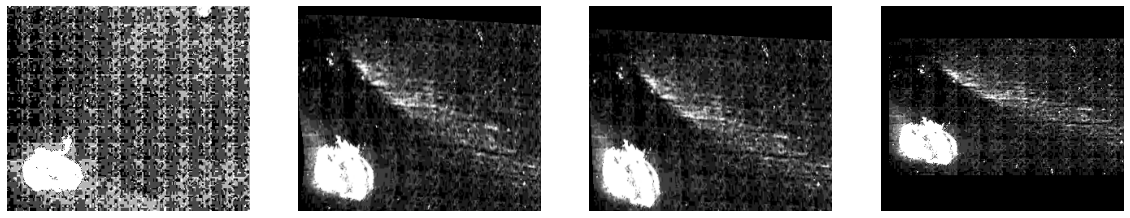

In [42]:
displayArr = [he_bboxed.convert('F'), ihc_bboxed_3, ihc_bboxed_2, ihc_bboxed_1]
display_n_2d_arrays(displayArr)

In [43]:
def displayAlternating(imArr, displayslider):
    display_n_2d_arrays([imArr[displayslider]], cmap=['gray'])

interact(displayAlternating,
         imArr =  fixed(displayArr),
         displayslider = (0,len(displayArr)-1,1))

interactive(children=(IntSlider(value=1, description='displayslider', max=3), Output()), _dom_classes=('widget…

<function __main__.displayAlternating(imArr, displayslider)>

### Running over whole db (with exceptions)

We exclude GIMP, unusable and rotation cases.

In [44]:
from PIL import Image
from datetime import datetime
import pytz
tz = pytz.timezone("Europe/Berlin")
print(datetime.now(tz).strftime("%d.%m.%Y, %H:%M:%S"))

14.08.2023, 17:24:56


In [41]:
# simdict = {}
# excepts=0
# runs = 0
# for index, pair in pair_df.iterrows():
#     if pair["graphic changes"] or pair["unusable"] or pair["rotate ihc degrees"]!=0:
#         continue
#     runs += 1
# #     try:
#     if True:
#         simdict[index] = {}
        
#         ihc_slide = slide.open_slide(pair["ihc path"])
#         he_slide = slide.open_slide(pair["he path"])

#         ihc_pic = ihc_slide.read_region((0,0),
#                                          level,
#                                          ihc_slide.level_dimensions[level])
#         he_pic = he_slide.read_region((0,0),
#                                      level,
#                                      he_slide.level_dimensions[level])

#         ihc_inv_contrast = get_contrast_image(ihc_pic)
#         he_inv_contrast = get_contrast_image(he_pic)
#         needsCropping = ((
#             pair["crop ihc left"] +
#             pair["crop ihc top"] +
#             pair["crop ihc right"] +
#             pair["crop ihc bottom"] +
#             pair["crop he left"] +
#             pair["crop he top"] +
#             pair["crop he right"] +
#             pair["crop he bottom"]) > 0)

#         if pair["graphic changes"] == True:
#             ihc_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_IHC.png'))
#             he_inv_contrast = Image.open(output_path/('ContrastImsEdited/'+ str(index) +'_HE.png'))
#         elif needsCropping == True:
#             he_alpha = Image.new("L", he_pic.size, 0)
#             draw = ImageDraw.Draw(he_alpha)
#             draw.rectangle((pair["crop he left"],
#                             pair["crop he top"],
#                             he_pic.size[0]-pair["crop he right"],
#                             he_pic.size[1]-pair["crop he bottom"]
#                          ), fill=255)

#             ihc_alpha = Image.new("L", ihc_pic.size, 0)
#             draw = ImageDraw.Draw(ihc_alpha)
#             draw.rectangle((pair["crop ihc left"],
#                             pair["crop ihc top"],
#                             ihc_pic.size[0]-pair["crop ihc right"],
#                             ihc_pic.size[1]-pair["crop ihc bottom"]
#                          ), fill=255)
#             he_black = Image.new("L", he_pic.size, 0)
#             ihc_black = Image.new("L", ihc_pic.size, 0)

#             he_inv_contrast = Image.composite(he_inv_contrast, he_black, he_alpha)
#             ihc_inv_contrast = Image.composite(ihc_inv_contrast, ihc_black, ihc_alpha)

#         doublesize = (2*max(he_inv_contrast.size[0], ihc_inv_contrast.size[0]),
#                       2*max(he_inv_contrast.size[1], ihc_inv_contrast.size[1]))
#         he_inv_contrast_ds = he_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])
#         ihc_inv_contrast_ds = ihc_inv_contrast.crop([0,0,doublesize[0],doublesize[1]])

#         fixed_image =  sitk.GetImageFromArray(np.array(he_inv_contrast_ds).astype('float32'))
#         moving_image = sitk.GetImageFromArray(np.array(ihc_inv_contrast_ds).astype('float32'))

#         # let's measure the similarity after the initial transform first
#         he_com_yx = ndi.center_of_mass(np.array(he_inv_contrast))
#         he_com_yx = (int(he_com_yx[0]), int(he_com_yx[1]))
#         ihc_com_yx = ndi.center_of_mass(np.array(ihc_inv_contrast))
#         ihc_com_yx = (int(ihc_com_yx[0]), int(ihc_com_yx[1]))

#         trl_transform_1 = sitk.TranslationTransform(2, [ihc_com_yx[1]-he_com_yx[1], ihc_com_yx[0]-he_com_yx[0]])
#         moving_image_trltd_1 = sitk.Resample(moving_image, trl_transform_1, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
#         moving_im_trltd_1_pil = Image.fromarray(sitk.GetArrayViewFromImage(moving_image_trltd_1))

#         simdict[index] = {}

#         he_bbox = he_inv_contrast.getbbox()
#         ihc_bboxed_1 = moving_im_trltd_1_pil.crop(he_bbox)
#         he_bboxed = he_inv_contrast.crop(he_bbox)#.convert('F') # has type 'L', but that doesn't change the metrics, so whatever
#         calculateMetrics(he_bboxed, ihc_bboxed_1, simdict[index], "1: CoM translated")

#         aff_tfm = sitk.ReadTransform(pair["aff path"])
#         moving_image_aff = sitk.Resample(moving_image, aff_tfm, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
#         moving_im_aff_pil = Image.fromarray(sitk.GetArrayViewFromImage(moving_image_aff))
#         ihc_bboxed_2 = moving_im_aff_pil.crop(he_bbox)
#         calculateMetrics(he_bboxed, ihc_bboxed_2, simdict[index], "2: Affine transformed")

#         bsp_tfm = sitk.ReadTransform(pair["bsp path"])
#         composite = sitk.CompositeTransform([aff_tfm, bsp_tfm])
#         moving_image_bsp = sitk.Resample(moving_image, composite, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
#         moving_im_bsp_pil = Image.fromarray(sitk.GetArrayViewFromImage(moving_image_bsp))
#         ihc_bboxed_3 = moving_im_bsp_pil.crop(he_bbox)
#         calculateMetrics(he_bboxed, ihc_bboxed_3, simdict[index], "3: BSpline transformed")

#         with open('out.txt', 'a+') as f:
#             print(datetime.now(tz).strftime("%d.%m.%Y, %H:%M:%S") + ': it ' + str(index) + ' successful', file=f)  # Python 3.x
# #     except:
# #         excepts += 1
# #         with open('out.txt', 'a+') as f:
# #             print("___________", file=f)
# #             print(datetime.now(tz).strftime("%d.%m.%Y, %H:%M:%S") + ': it ' + pair_ihc_name + ' except' + str(excepts) + ':', file=f)  # Python 3.x
# #             print(sys.exc_info(), file=f)
# #         continue
        
# with open('out.txt', 'a+') as f:
#     print("\n___", file=f)
#     print("Number of excepts: " + str(excepts), file=f)
#     print("___\n", file=f)

The cell above took 18 minutes to execute

In [42]:
# output_path = Path('Output')
# output_path.mkdir(exist_ok=True)
# with open(output_path/'simdict.txt', 'w') as f:
#     print(simdict, file=f)  # Python 3.x

### Boxplots

In [45]:
simdict = eval(open(output_path/'simdict.txt', 'r').read())

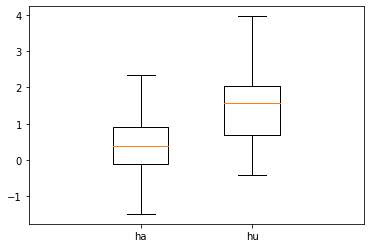

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(42)

x = np.array([1,2])
data1 = np.array([np.random.normal(loc=0.5,size=100),np.random.normal(loc=1.5,size=100)]).T
plt.figure()
plt.boxplot(data1,0,'',positions=x,widths=0.5)
plt.xlim(0,3)
plt.xticks(x, ["ha", "hu"])
plt.show()

What format does data1 have? We have to imitate it

In [47]:
data1[:5]

array([[0.99671415, 0.08462926],
       [0.3617357 , 1.07935468],
       [1.14768854, 1.15728548],
       [2.02302986, 0.69772273],
       [0.26584663, 1.33871429]])

Pretty straightforward!

In [48]:
[(x, simdict[x]) for x in simdict][0]

(0,
 {'mse': {'1: CoM translated': 0.0489,
   '2: Affine transformed': 0.0446,
   '3: BSpline transformed': 0.0153},
  'ssim_winNone': {'1: CoM translated': 0.6036,
   '2: Affine transformed': 0.6326,
   '3: BSpline transformed': 0.7091},
  'ssim_winmax': {'1: CoM translated': 0.8929,
   '2: Affine transformed': 0.9011,
   '3: BSpline transformed': 0.9667},
  'correlation': {'1: CoM translated': -0.8002,
   '2: Affine transformed': -0.8158,
   '3: BSpline transformed': -0.9336},
  'MattesMI': {'1: CoM translated': -0.5579,
   '2: Affine transformed': -0.6383,
   '3: BSpline transformed': -0.736}})

In [49]:
formattedSimDict = {}
for ihc_id in simdict:
    for metric in simdict[ihc_id]:
        if not metric in formattedSimDict:
            formattedSimDict[metric] = {}
        for phase in simdict[ihc_id][metric]:
            if not phase in formattedSimDict[metric]:
                formattedSimDict[metric][phase] = []
            formattedSimDict[metric][phase].append(simdict[ihc_id][metric][phase])

In [50]:
list(formattedSimDict.keys())[0]

'mse'

mse:
ssim_winNone:
ssim_winmax:
correlation:
MattesMI:


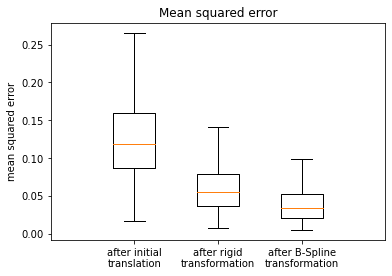

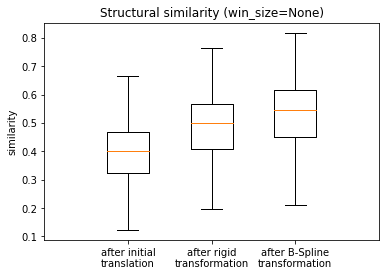

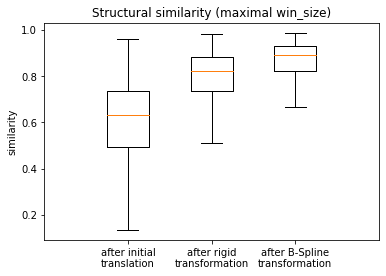

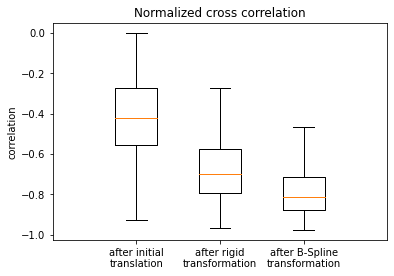

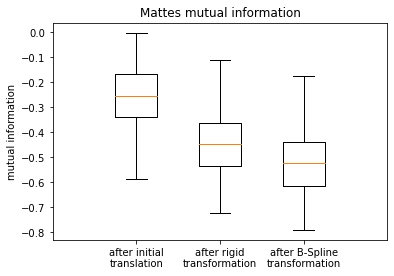

In [ ]:
ind = 0
metricStrings = [
    "Mean squared error",
    "Structural similarity (win_size=None)",
    "Structural similarity (maximal win_size)",
    "Normalized cross correlation",
    "Mattes mutual information"
]
yStrings = [
    "mean squared error",
    "similarity",
    "similarity",
    "correlation",
    "mutual information"
]
for metric in formattedSimDict:
    print(metric + ":")
    x = np.array([1,2,3])
    dataOfMetric = [formattedSimDict[metric][x] for x in formattedSimDict[metric]]
    plt.figure()
    plt.boxplot(dataOfMetric,0,'',positions=x,widths=0.5)
    plt.xlim(0,4)
    plt.xticks(x, ['after initial\ntranslation','after linear\ntransformation','after B-Spline\ntransformation'])#, list(formattedSimDict[metric].keys()))
    plt.title(metricStrings[ind])
    plt.ylabel(yStrings[ind])
    plt.savefig('sim_'+str(metric)+'.png', dpi=300)
#     plt.show()
    ind += 1

Good

**How do we find out mean values?**

(e.g., the mean for `ssim_winNone`, before and after?)

In [58]:
print("Before: " + str(round(np.mean(formattedSimDict['ssim_winNone']['1: CoM translated']), 8)))
print("After: " + str(round(np.mean(formattedSimDict['ssim_winNone']['3: BSpline transformed']), 8)))

Before: 0.39437185
After: 0.52740277


**Variance**

In [73]:
for metric in formattedSimDict:
    for x in formattedSimDict[metric]:
        print(metric+", " + x + ": "+str(round(np.var(formattedSimDict[metric][x]), 8)))

mse, 1: CoM translated: 0.00342292
mse, 2: Affine transformed: 0.00165586
mse, 3: BSpline transformed: 0.0013882
ssim_winNone, 1: CoM translated: 0.01286727
ssim_winNone, 2: Affine transformed: 0.01475904
ssim_winNone, 3: BSpline transformed: 0.01648569
ssim_winmax, 1: CoM translated: 0.0405971
ssim_winmax, 2: Affine transformed: 0.02036892
ssim_winmax, 3: BSpline transformed: 0.01881266
correlation, 1: CoM translated: 0.04087546
correlation, 2: Affine transformed: 0.0256854
correlation, 3: BSpline transformed: 0.02192717
MattesMI, 1: CoM translated: 0.01452244
MattesMI, 2: Affine transformed: 0.01589525
MattesMI, 3: BSpline transformed: 0.01800359


### Calculating significance

First, let's find out how many samples we used:

In [61]:
len(pair_df[(pair_df["graphic changes"] == False) & (pair_df["rotate ihc degrees"]==0) & (pair_df["unusable"]==False)])

650

Is that even necessary? Apparently not.

In [62]:
formattedSimDict.keys()

dict_keys(['mse', 'ssim_winNone', 'ssim_winmax', 'correlation', 'MattesMI'])

In [63]:
# formattedSimDict

In [64]:
data = {}
for metric in formattedSimDict:
    data[metric] = {"trl":[], "aff":[], "bsp":[]}
    for i in range(0,3):
        dataKey = list(data[metric].keys())[i]
        simdictKey = list(formattedSimDict[metric].keys())[i]
        data[metric][dataKey] = formattedSimDict[metric][simdictKey].copy()

In [65]:
data.keys()

dict_keys(['mse', 'ssim_winNone', 'ssim_winmax', 'correlation', 'MattesMI'])

In [66]:
from itertools import combinations
from scipy.stats import ttest_ind
test_metric = "mse"
for list1, list2 in combinations(data[test_metric].keys(), 2):
    t, p = ttest_ind(data[test_metric][list1], data[test_metric][list2])
    print (list1, list2, p)

trl aff 2.4457358557726767e-98
trl bsp 1.2744323583576025e-159
aff bsp 1.0649395527969927e-20


In [67]:
test_metric = "ssim_winNone"
for list1, list2 in combinations(data[test_metric].keys(), 2):
    t, p = ttest_ind(data[test_metric][list1], data[test_metric][list2])
    print (list1, list2, p)

trl aff 3.94421512177112e-39
trl bsp 2.4950109891843292e-76
aff bsp 1.597055273375575e-10


In [68]:
test_metric = "ssim_winmax"
for list1, list2 in combinations(data[test_metric].keys(), 2):
    t, p = ttest_ind(data[test_metric][list1], data[test_metric][list2])
    print (list1, list2, p)

trl aff 1.8774652879362476e-81
trl bsp 7.298609541338677e-130
aff bsp 3.879448552557295e-15


In [69]:
test_metric = "correlation"
for list1, list2 in combinations(data[test_metric].keys(), 2):
    t, p = ttest_ind(data[test_metric][list1], data[test_metric][list2])
    print (list1, list2, p)

trl aff 1.1231555075374964e-120
trl bsp 1.2412412548305214e-206
aff bsp 4.372589246896501e-31


In [70]:
test_metric = "MattesMI"
for list1, list2 in combinations(data[test_metric].keys(), 2):
    t, p = ttest_ind(data[test_metric][list1], data[test_metric][list2])
    print (list1, list2, p)

trl aff 7.616686805959448e-129
trl bsp 2.553493968079403e-197
aff bsp 6.364570843545596e-21


Yeah, that's pretty telling.

"Conventionally, p < 0.05 is referred as statistically significant and p < 0.001 as statistically highly significant."

So everything is highly significant. Every step in every metric

## Information for publication

### versions of stuff

In [348]:
import scipy
scipy.__version__

'1.6.3'

In [350]:
import ipywidgets
ipywidgets.__version__

'7.6.3'

In [351]:
import PIL
PIL.__version__

'8.2.0'

In [352]:
pd.__version__

'1.2.4'

In [354]:
import skimage
skimage.__version__

'0.18.1'

In [355]:
matplotlib.__version__

'3.4.2'

In [356]:
np.__version__

'1.20.3'

### Pixel size

In [213]:
help(slide.get_conversion_factor)

Help on function get_conversion_factor in module slide:

get_conversion_factor(wsi_path: pathlib.Path, level: int) -> float
    Arguments:
        wsi_path: path to a whole-slide image
        level: level of the whole-slide image, 0 means highest resolution, with every level the resolution halves
    Result:
        returns a conversion factor, to convert pixel size into micrometer



In [216]:
conv_fac = slide.get_conversion_factor(pair["ihc path"],7)
conv_fac

28.22180575460258

=> 28 µm per pixel

In [217]:
1000/conv_fac

35.43359375

=> 35 pixels per mm

Highest res:

In [218]:
slide.get_conversion_factor(pair["ihc path"],0)

0.22048285745783266

=> 0.22µm per pixel

In [219]:
1000/slide.get_conversion_factor(pair["ihc path"],0)

4535.5

=> 4,535.5 pixels per mm

### Percentages of best affine transforms

In [43]:
import pathlib
from pathlib import Path
output_path = Path('Output')

import pandas as pd
pair_df = pd.read_csv(output_path/'pairlist_df_3-Copy_FINAL_2023-04-06.csv')

In [48]:
pair_df[(pair_df["unusable"] == False)]['best aff tfm'].value_counts()

reg aff        486
reg eul        134
reg trl         45
initial trl      8
Name: best aff tfm, dtype: int64

In [46]:
len(pair_df[(pair_df["unusable"] == False)])

673

In [47]:
pair_df[(pair_df["unusable"] == False)]['best aff tfm'].value_counts()/673

reg aff        0.722140
reg eul        0.199108
reg trl        0.066865
initial trl    0.011887
Name: best aff tfm, dtype: float64

## For how many cases was a simple rerun helpful?

In [7]:
import pathlib
from pathlib import Path
output_path = Path('Output')

import pandas as pd
pair_df = pd.read_csv(output_path/'pairlist_df_3-Copy_FINAL_2023-04-06.csv')

In [22]:
pair_df.columns

Index(['ihc name', 'he name', 'ihc path', 'he path', 'case', 'labels',
       'trl registration duration', 'eul registration duration',
       'aff registration duration', 'aff path', 'best aff tfm', 'bsp path',
       'bsp registration duration', 'attempts', 'full duration',
       'crop ihc left', 'crop ihc top', 'crop ihc right', 'crop ihc bottom',
       'crop he left', 'crop he top', 'crop he right', 'crop he bottom',
       'rotate ihc degrees', 'needed adjustments', 'multiple configs',
       'graphic changes', 'rerun', 'unusable'],
      dtype='object')

In [17]:
len(pair_df[pair_df["attempts"]==0])

0

In [16]:
len(pair_df[pair_df["attempts"]==1])

542

In [18]:
len(pair_df[pair_df["attempts"]==2])

116

In [19]:
len(pair_df[pair_df["attempts"]==3])

16

In [20]:
len(pair_df[pair_df["attempts"]==4])

0

In [21]:
(len(pair_df) ==
     len(pair_df[pair_df["attempts"]==1]) +
     len(pair_df[pair_df["attempts"]==2]) +
     len(pair_df[pair_df["attempts"]==3]))

True

Okay, but here's the real question:

In [46]:
len(pair_df[  (pair_df["attempts"] == 2)
        & (pair_df["needed adjustments"] == False)
        & (pair_df["multiple configs"] == False)
        & (pair_df["graphic changes"] == False)
        & (pair_df["rotate ihc degrees"] == 0)
        & (pair_df["crop he left"] == 0)
        & (pair_df["crop he top"] == 0)
        & (pair_df["crop he right"] == 0)
        & (pair_df["crop he bottom"] == 0)
        & (pair_df["crop ihc left"] == 0)
        & (pair_df["crop ihc top"] == 0)
        & (pair_df["crop ihc right"] == 0)
        & (pair_df["crop ihc bottom"] == 0)
       ])

2

In [47]:
len(pair_df[  (pair_df["attempts"] == 3)
        & (pair_df["needed adjustments"] == False)
        & (pair_df["multiple configs"] == False)
        & (pair_df["graphic changes"] == False)
        & (pair_df["rotate ihc degrees"] == 0)
        & (pair_df["crop he left"] == 0)
        & (pair_df["crop he top"] == 0)
        & (pair_df["crop he right"] == 0)
        & (pair_df["crop he bottom"] == 0)
        & (pair_df["crop ihc left"] == 0)
        & (pair_df["crop ihc top"] == 0)
        & (pair_df["crop ihc right"] == 0)
        & (pair_df["crop ihc bottom"] == 0)
       ])

1

Alright. The number is so small that it's possible that the first and second attempt actually resulted in the same transformation and that it was merely my quality demands that had declined in the meantime.

## Time effort and percentage of outliers

In [7]:
import pathlib
from pathlib import Path
output_path = Path('Output')

import pandas as pd

pair_df = pd.read_csv(output_path/'pairlist_df_3-Copy-before-rerun_2023.04.06.csv')

In [8]:
pair_df.columns

Index(['ihc name', 'he name', 'ihc path', 'he path', 'case', 'labels',
       'trl registration duration', 'eul registration duration',
       'aff registration duration', 'aff path', 'best aff tfm', 'bsp path',
       'bsp registration duration', 'attempts', 'full duration',
       'crop ihc left', 'crop ihc top', 'crop ihc right', 'crop ihc bottom',
       'crop he left', 'crop he top', 'crop he right', 'crop he bottom',
       'rotate ihc degrees', 'needed adjustments', 'multiple configs',
       'graphic changes', 'rerun', 'unusable'],
      dtype='object')

### Time effort

In [126]:
pair_df["full duration"].min()

0.0

Ah, everything from 616 onward is without time because it was added after the first run.

In [127]:
pair_df[pair_df.index<617]["full duration"].min(), pair_df[pair_df.index<616]["full duration"].min()

(0.0, 2447.0)

In [128]:
pair_df[pair_df.index<616]["full duration"].mean()

10579.996753246753

In [129]:
pair_df[pair_df.index<616]["trl registration duration"].mean()

1110.5324675324675

In [130]:
pair_df[pair_df.index<616]["eul registration duration"].mean()

1105.3733766233765

In [131]:
pair_df[pair_df.index<616]["aff registration duration"].mean()

1150.060064935065

In [132]:
pair_df[pair_df.index<616]["bsp registration duration"].mean()

6549.347402597403

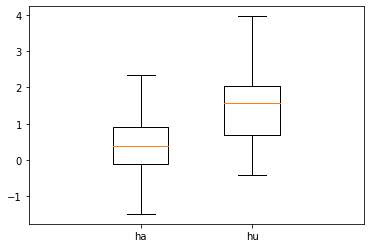

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(42)

x = np.array([1,2])
data1 = np.array([np.random.normal(loc=0.5,size=100),np.random.normal(loc=1.5,size=100)]).T
plt.figure()
plt.boxplot(data1,0,'',positions=x,widths=0.5)
plt.xlim(0,3)
plt.xticks(x, ["ha", "hu"])
plt.show()

What format does data1 have? We have to imitate it

In [134]:
data1[:5]

array([[0.99671415, 0.08462926],
       [0.3617357 , 1.07935468],
       [1.14768854, 1.15728548],
       [2.02302986, 0.69772273],
       [0.26584663, 1.33871429]])

In [135]:
len(data1)

100

Pretty straightforward!

In [136]:
durationData = []
durationData.append([x/1000 for x in list(pair_df[pair_df.index<616]["trl registration duration"])])
durationData.append([x/1000 for x in list(pair_df[pair_df.index<616]["eul registration duration"])])
durationData.append([x/1000 for x in list(pair_df[pair_df.index<616]["aff registration duration"])])
durationData.append([x/1000 for x in list(pair_df[pair_df.index<616]["bsp registration duration"])])
durationData.append([x/1000 for x in list(pair_df[pair_df.index<616]["full duration"])])
durationData[0][:5]

[0.615, 0.609, 1.424, 1.33, 0.811]

trl, eul, aff, bsp:


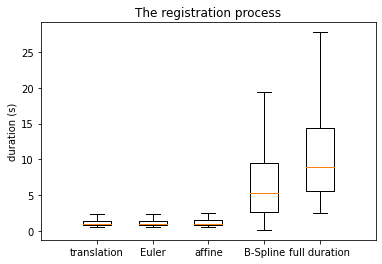

In [138]:
print("trl, eul, aff, bsp:")
x = np.array([1,2,3,4,5])
plt.figure()
plt.boxplot(durationData,0,'',positions=x,widths=0.5)
plt.xlim(0,6)
plt.xticks(x, ['translation','Euler','affine','B-Spline','full duration',])#, list(formattedSimDict[metric].keys()))
plt.title("The registration process")
plt.ylabel("duration (s)")
plt.savefig('durations.png', dpi=300)
#     plt.show()

### Percentage of outliers

In [9]:
pair_df = pd.read_csv(output_path/'pairlist_df_3-Copy_FINAL_2023-04-06.csv')

In [17]:
len(pair_df[pair_df.index<616][(pair_df["needed adjustments"]==False) & (pair_df["attempts"] < 3)])

<ipython-input-17-a998d0e54c32>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(pair_df[pair_df.index<616][(pair_df["needed adjustments"]==False) & (pair_df["attempts"] < 3)])


544

In [16]:
len(pair_df[pair_df.index<616][(pair_df["attempts"] == 3)])

<ipython-input-16-a9783e978289>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(pair_df[pair_df.index<616][(pair_df["attempts"] == 3)])


10

In [11]:
len(pair_df[pair_df.index<616][(pair_df["graphic changes"]) & (pair_df["attempts"] < 3)])

<ipython-input-11-daf9fa7c3b2c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(pair_df[pair_df.index<616][(pair_df["graphic changes"]) & (pair_df["attempts"] < 3)])


6

In [12]:
len(pair_df[pair_df.index<616][(pair_df["multiple configs"]) & (pair_df["graphic changes"] == False) & (pair_df["attempts"] < 3)])

<ipython-input-12-523c94468254>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(pair_df[pair_df.index<616][(pair_df["multiple configs"]) & (pair_df["graphic changes"] == False) & (pair_df["attempts"] < 3)])


20

In [15]:
len(pair_df[pair_df.index<616][(pair_df["rotate ihc degrees"] != 0) & (pair_df["attempts"] < 3)])

<ipython-input-15-dd9669569c45>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(pair_df[pair_df.index<616][(pair_df["rotate ihc degrees"] != 0) & (pair_df["attempts"] < 3)])


8

In [18]:
len(pair_df[pair_df.index<616][
    (pair_df["attempts"] < 3) & 
    (pair_df["needed adjustments"]) &
    (pair_df["graphic changes"] == False) &
    (pair_df["multiple configs"] == False) & 
    (pair_df["rotate ihc degrees"] == 0)
])

<ipython-input-18-a9a19aca6d61>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(pair_df[pair_df.index<616][


28

In [19]:
len(pair_df[pair_df.index<616][
    (pair_df["attempts"] < 3) & 
    (pair_df["needed adjustments"]) &
    (pair_df["graphic changes"] == False) &
    (pair_df["multiple configs"] == False) & 
    (pair_df["rotate ihc degrees"] == 0) &
    (
        (pair_df["crop ihc left"] != 0) |
        (pair_df["crop ihc top"] != 0) |
        (pair_df["crop ihc right"] != 0) |
        (pair_df["crop ihc bottom"] != 0) |
        (pair_df["crop he left"] != 0) |
        (pair_df["crop he top"] != 0) |
        (pair_df["crop he right"] != 0) |
        (pair_df["crop he bottom"] != 0) 
    )
])

<ipython-input-19-e5b23bfb79e6>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(pair_df[pair_df.index<616][


28

Sum: one too many. Where is the unusable case?

In [20]:
pair_df[pair_df["unusable"]]

(classified)


Let's correct this term then:

In [21]:
len(pair_df[pair_df.index<616][(pair_df["needed adjustments"]==False) & (pair_df["unusable"]==False) & (pair_df["attempts"] < 3)])

<ipython-input-21-e0d281af17d5>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(pair_df[pair_df.index<616][(pair_df["needed adjustments"]==False) & (pair_df["unusable"]==False) & (pair_df["attempts"] < 3)])


543

In [39]:
# len(pair_df[pair_df.index<616][
#     (pair_df["attempts"] == 3) &
#     (pair_df["needed adjustments"]) &
#     (pair_df["rotate ihc degrees"] == 0) &
#     (pair_df["graphic changes"] == False)
# ])

## Transformation times in relation to image size

### Prep

We want image size as the x axis and transformation times as the y axis, and we want it for trl, eul, aff and bsp transforms.

In [7]:
import pathlib
from pathlib import Path
output_path = Path('Output')

import pandas as pd
pair_df = pd.read_csv(output_path/'pairlist_df_3-Copy-before-rerun_2023.04.06.csv')

In [8]:
pair_df.columns

Index(['ihc name', 'he name', 'ihc path', 'he path', 'case', 'labels',
       'trl registration duration', 'eul registration duration',
       'aff registration duration', 'aff path', 'best aff tfm', 'bsp path',
       'bsp registration duration', 'attempts', 'full duration',
       'crop ihc left', 'crop ihc top', 'crop ihc right', 'crop ihc bottom',
       'crop he left', 'crop he top', 'crop he right', 'crop he bottom',
       'rotate ihc degrees', 'needed adjustments', 'multiple configs',
       'graphic changes', 'rerun', 'unusable'],
      dtype='object')

In [32]:
x = []
y_trl = []
y_eul = []
y_aff = []
y_bsp = []
y_full = []
for index, pair in pair_df[pair_df.index<616].iterrows():
    if pair["attempts"] > 2:
        continue;
    # to get the transformation size, we just sneakily use the bspline tfm size
    transform_dimensions = sitk.BSplineTransform(sitk.ReadTransform(pair["bsp path"].replace("/Transforms/", "/OldTransforms2/"))).GetTransformDomainPhysicalDimensions()
    x.append(((int)(transform_dimensions[0]) * (int)(transform_dimensions[1]))/1000000)
    y_trl.append(pair["trl registration duration"]/1000)
    y_eul.append(pair["eul registration duration"]/1000)
    y_aff.append(pair["aff registration duration"]/1000)
    y_bsp.append(pair["bsp registration duration"]/1000)
    y_full.append(pair["full duration"]/1000)

The cell above took longer to execute than expected, about 41 seconds

In [10]:
np.min(x)

0.056448

In [11]:
np.max(x)

5.92704

### Trl

0.45182357140981527 0.41366502003009653


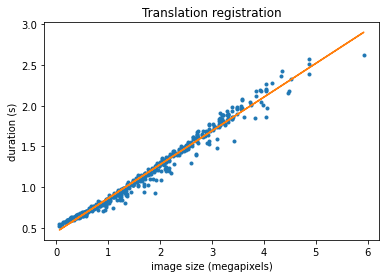

In [12]:
import numpy as np 
import matplotlib.pyplot as plt

#create basic scatterplot
plt.plot(x, y_trl, 'o', ms=3)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y_trl, 1)

#add linear regression line to scatterplot 
x_arr = np.array(x)
plt.plot(x_arr, m*x_arr+b)
plt.title("Translation registration")
plt.xlabel("image size (megapixels)")
plt.ylabel("duration (s)")
plt.savefig('dur_trl.png', dpi=300)
print(b, m)

→ Translation registration: 0.452 seconds as baseline, plus approx. 0.414 seconds per megapixel.

### Eul

0.45639623843457355 0.40755353760693497


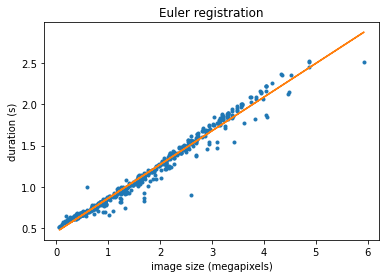

In [13]:
plt.plot(x, y_eul, 'o', ms=3)
m, b = np.polyfit(x, y_eul, 1)
plt.plot(x_arr, m*x_arr+b)
plt.xlabel("image size (megapixels)")
plt.ylabel("duration (s)")
plt.title("Euler registration")
plt.savefig('dur_eul.png', dpi=300)
print(b, m)

→ Euler registration: 0.456 seconds as baseline, plus approx. 0.408 seconds per megapixel.

### Aff

0.4419265945334039 0.44470334003678197


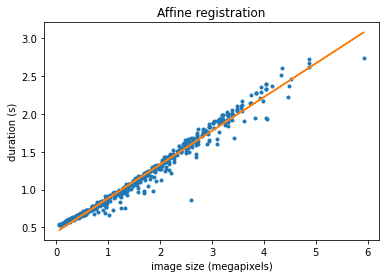

In [14]:
plt.plot(x, y_aff, 'o', ms=3)
m, b = np.polyfit(x, y_aff, 1)
plt.plot(x_arr, m*x_arr+b)
plt.title("Affine registration")
plt.xlabel("image size (megapixels)")
plt.ylabel("duration (s)")
plt.savefig('dur_aff.png', dpi=300)
print(b, m)

→ Affine registration: 0.442 seconds as baseline, plus approx. 0.445 seconds per megapixel.

### Bsp

1.1045730663189408 3.4192838416692704


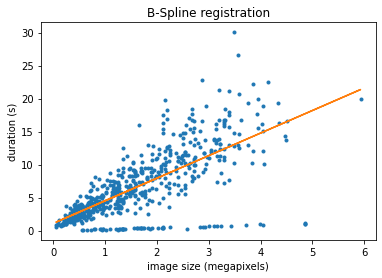

In [123]:
plt.plot(x, y_bsp, 'o', ms=3)
m, b = np.polyfit(x, y_bsp, 1)
plt.plot(x_arr, m*x_arr+b)
plt.title("B-Spline registration")
plt.xlabel("image size (megapixels)")
plt.ylabel("duration (s)")
plt.savefig('dur_bsp.png', dpi=300)
print(b, m)

→ BSpline registration: 1.105 seconds as baseline, plus approx. 3.419 seconds per megapixel (high variance)

Fascinating, there's a horizontal line close to the 0s line there.

In [29]:
outlierpair = None
outlierpairSize = 0
special_pair_df = pd.DataFrame(columns = pair_df.columns)
for index, pair in pair_df[pair_df.index<616].iterrows():
    if pair["attempts"] > 2:
        continue;
    # to get the transformation size, we just sneakily use the bspline tfm size
    transform_dimensions = sitk.BSplineTransform(sitk.ReadTransform(pair["bsp path"].replace("/Transforms/", "/OldTransforms2/"))).GetTransformDomainPhysicalDimensions()
    sizeInMP = (((int)(transform_dimensions[0]) * (int)(transform_dimensions[1]))/1000000)
    bspDurInS = pair["bsp registration duration"]/1000
    if sizeInMP > 0.5 and bspDurInS<1.1:
        special_pair_df.loc[index] = pair_df.iloc[index]
        if (outlierpair is None
            or outlierpair["bsp registration duration"] / outlierpairSize < pair["bsp registration duration"] / sizeInMP):
            outlierpair = pair
            outlierpairSize = sizeInMP

Again, long execution time. 28 seconds. Weird.

In [30]:
outlierpair["bsp registration duration"], outlierpairSize

(140.0, 0.550368)

In [24]:
special_pair_df["bsp registration duration"].max()

1096.0

In [31]:
pd.set_option('display.max_columns', None)
special_pair_df

(classified)


Let's look at them

#### Interact Cell A

In [119]:
ind = -1

In [120]:
ind += 1
global_index = list(special_pair_df.index)[ind]
print(global_index)
callback_After_Iteration = loadAndShowPair
loadAndShowPair()

(classified)


### Full

2.7781895910619356 4.8994855466703795


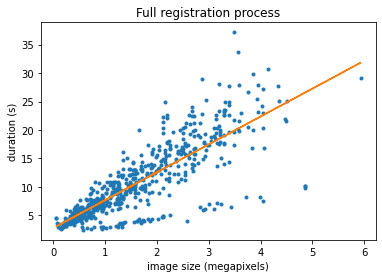

In [34]:
plt.plot(x, y_full, 'o', ms=3)
m, b = np.polyfit(x, y_full, 1)
plt.plot(x_arr, m*x_arr+b)
plt.title("Full registration process")
plt.xlabel("image size (megapixels)")
plt.ylabel("duration (s)")
plt.savefig('dur_full.png', dpi=300)
print(b, m)

→ Full registration: 2.778 seconds as baseline, plus approx. 4.899 seconds per megapixel

## Image sizes boxplot

In [334]:
pair_df = pd.read_csv(output_path/'pairlist_df_3-Copy-before-rerun_2023.04.06.csv')

In [335]:
pair_df.columns

Index(['ihc name', 'he name', 'ihc path', 'he path', 'case', 'labels',
       'trl registration duration', 'eul registration duration',
       'aff registration duration', 'aff path', 'best aff tfm', 'bsp path',
       'bsp registration duration', 'attempts', 'full duration',
       'crop ihc left', 'crop ihc top', 'crop ihc right', 'crop ihc bottom',
       'crop he left', 'crop he top', 'crop he right', 'crop he bottom',
       'rotate ihc degrees', 'needed adjustments', 'multiple configs',
       'graphic changes', 'rerun', 'unusable'],
      dtype='object')

In [328]:
pair_df[pair_df.index<616]["bsp registration duration"].mean()

6549.347402597403

In [336]:
widthlist = []
heightlist = []
sizelist = []
for index, pair in pair_df[pair_df.index<616].iterrows():
    # to get the transformation size, we just sneakily use the bspline tfm size
    transform_dimensions = sitk.BSplineTransform(sitk.ReadTransform(pair["bsp path"].replace("/Transforms/", "/OldTransforms2/"))).GetTransformDomainPhysicalDimensions()
    widthlist.append(((int)(transform_dimensions[0]))/1000)
    heightlist.append(((int)(transform_dimensions[1]))/1000)
    sizelist.append(((int)(transform_dimensions[0]) * (int)(transform_dimensions[1]))/1000000)

In [337]:
sizeData = []
sizeData.append(widthlist)
sizeData.append(heightlist)
sizeData.append(sizelist)
sizeData[0][:5]

[0.504, 0.504, 1.344, 1.288, 0.952]

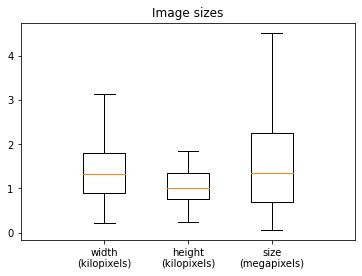

In [340]:
x = np.array([1,2,3])
plt.figure()
plt.boxplot(sizeData,0,'',positions=x,widths=0.5)
plt.xlim(0,4)
plt.xticks(x, ['width\n(kilopixels)', 'height\n(kilopixels)', 'size\n(megapixels)'])#, list(formattedSimDict[metric].keys()))
plt.title("Image sizes")
plt.savefig('sizes.png', dpi=300)
#     plt.show()